In [163]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyodbc
import math
from scipy import optimize

pd.set_option('display.max_columns',999)
pd.set_option('precision',4)

In [2]:
#ll.id = 2 is Bruce Lake Lateral
#ll.id = 3 is Ear Falls Lateral

server = 'sql2016test'
    
db = 'DRAS_IRASv6_Training'
driver = '{SQL Server Native Client 11.0}'

conn = pyodbc.connect("Driver="+driver+";Server="+server+";Database="+db+";Trusted_Connection=yes;")

q0 = """set nocount on;
        select ld.code [status], ld2.code [type], f.ILIFComment, f.* from InlineInspectionFeature f
        join ListDomain ld on f.ILIFStatusDomainId = ld.id
        join ListDomain ld2 on f.ILIFTypeDomainId = ld2.Id
        where f.InlineInspectionRangeId = 32


        order by f.StationNum asc"""
df = pd.read_sql_query(q0,conn)

q1 = """set nocount on;
        select ld.code [status], ld2.code [type], f.ILINCDComment, f.* from InlineInspectionNonCrsnDfct f
        join ListDomain ld on f.ILINCDStatusDomainId = ld.id
        join ListDomain ld2 on f.ILINCDTypeDomainId = ld2.Id
        where f.InlineInspectionRangeId = 32"""

ncd = pd.read_sql_query(q1,conn)

q2 = """set nocount on;
        select ep.Elevation, ep.StationNum from elevationprofile ep
        join stationseries ss on ep.stationseriesid = ss.id
        join lineloop ll on ss.lineloopid = ll.id
        where ll.id in (2,3)"""

elevation = pd.read_sql_query(q2,conn)

q3 = """set nocount on;
        select f.* from InlineInspectionJoint f
        where f.InlineInspectionRangeId = 32"""

joint = pd.read_sql_query(q3,conn)

q4 = """set nocount on;
        select ld.code [type], c.CrossingName, c.CrossingComment, c.CrossingWidth, cl.* from CrossingLocn cl
        join StationSeries ss on cl.StationSeriesId = ss.Id
        join LineLoop ll on ss.LineLoopId = ll.Id
        join Crossing c on cl.CrossingId = c.Id
        join ListDomain ld on c.CrossingTypeDomainId = ld.Id
        where ll.id in (2,3)
        order by cl.StationNum asc"""

crossing = pd.read_sql_query(q4,conn)

q5 = """set nocount on;
        select cd.* from CoverDepthProfile cd
        join StationSeries ss on cd.StationSeriesId = ss.Id
        join LineLoop ll on ss.LineLoopId = ll.Id
        where ll.id in (2)
        order by cd.StationNum asc"""

cover_depth = pd.read_sql_query(q5,conn)

conn.close()

In [3]:
df.set_index('StationNum', inplace=True)
joint.set_index('StationNum', inplace=True)
crossing.set_index('StationNum',inplace=True)
cover_depth.set_index('StationNum',inplace=True)

In [4]:
joint.sort_index(inplace=True)

In [5]:
crossing.sort_index(inplace=True)

In [6]:
cover_depth.sort_index(inplace=True)

Following cell contains the test section boundaries

In [7]:
t_s_1 = (0.,19731.)
t_s_2 = (19731.,44527.58)
t_s_3 = (44527.58,65578.5)
t_s_4 = (65578.5,82142.)
t_s_5 = (82142.,110914.7)
t_s_6 = (110914.7,130000)

# TOC
<a id="toc"></a>
* [ELEVATION DATA PROCESSING](#second)
* [CORROSION MONTE CARLO ANALYSIS](#first)
* [MANUFACTURING ANOMALY ASSESSMENT](#manu)
* [DEFORMATION AND DENT ASSESSMENT](#third)

# ELEVATION DATA PROCESSING 
<a id="second"></a>

* [TOC](#toc)

In [8]:
elevation.describe()

,Elevation,StationNum
count,874.0000,874.0000
mean,379.0085,53163.5809
std,21.2014,33244.9826
min,249.4200,25.0110
25%,365.5850,27432.4950
50%,378.8650,47800.8055
75%,389.8175,74013.4978
max,459.7100,127404.7070


In [9]:
elevation.set_index('StationNum', inplace=True)

In [10]:
'''t_s_1 = (0.,19731.)
t_s_2 = (19731.,44527.58)
t_s_3 = (44527.58,65578.5)
t_s_4 = (65578.5,82142.)
t_s_5 = (82142.,110914.7)
t_s_6 = (110914.7,130000)
'''

criteria_ele = [elevation.index.to_series().between(t_s_1[0],t_s_1[1]),
           elevation.index.to_series().between(t_s_2[0],t_s_2[1]),
           elevation.index.to_series().between(t_s_3[0],t_s_3[1]),
           elevation.index.to_series().between(t_s_4[0],t_s_4[1]),
           elevation.index.to_series().between(t_s_5[0],t_s_5[1]),
           elevation.index.to_series().between(t_s_6[0],t_s_6[1])]

values = ['test section 1',
         'test section 2',
         'test section 3',
         'test section 4',
         'test section 5',
         'test section 6']
elevation['section'] = np.select(criteria_ele, values, 0)

In [11]:
elevation.loc[elevation.index.to_series().between(-0.636,19703.2),:].max()

Elevation             399.4
section      test section 1
dtype: object

In [12]:
elevation_grouped = elevation.groupby('section').agg(['max','idxmax','min','idxmin'])

In [13]:
elevation_grouped['ED'] = elevation_grouped.iloc[:,0]-elevation_grouped.iloc[:,2]

In [14]:
elevation_grouped['TDP'] = elevation_grouped.ED*9.81

In [15]:
elevation_grouped['HPP'] = 5900.0

In [16]:
elevation_grouped['LPP'] = elevation_grouped.HPP + elevation_grouped.TDP

In [17]:
elevation_grouped['pctSMYS'] = elevation_grouped.LPP / ((2*172.0*1000*4.78)/(8.625*25.4))

In [18]:
TPL = pd.Series([370.7,388.5,388.5,372.8,364.0,358.2], index=['test section 1','test section 2','test section 3','test section 4','test section 5','test section 6'])
elevation_grouped['TPL'] = TPL
elevation_grouped['TP-LP'] = (elevation_grouped.TPL-elevation_grouped.iloc[:,2])*9.81
elevation_grouped['HP-TP'] = (elevation_grouped.iloc[:,0]-elevation_grouped.TPL)*9.81
elevation_grouped['TPP(from TP-LP)'] = elevation_grouped.LPP-elevation_grouped['TP-LP']
elevation_grouped['TPP(from HP-TP)'] = elevation_grouped.HPP+elevation_grouped['HP-TP']

Don't know what this next cell is trying to do. Don't run, or else wrong results will be obtained.

In [19]:
# elevation_grouped['LPP'] = elevation_grouped['TP-LP']*9.81+elevation_grouped['TPP(from TP-LP)']
# elevation_grouped['HPP'] = -elevation_grouped['HP-TP']*9.81+elevation_grouped['TPP(from HP-TP)']

In [20]:
elevation_grouped['LPP_pct_SMYS'] = elevation_grouped.LPP / ((2*172.0*1000*4.78)/(8.625*25.4))
elevation_grouped['HPP_pct_SMYS'] = elevation_grouped.HPP / ((2*172.0*1000*4.78)/(8.625*25.4))

In [21]:
elevation_grouped.HPP/4200

section
test section 1    1.4048
test section 2    1.4048
test section 3    1.4048
test section 4    1.4048
test section 5    1.4048
test section 6    1.4048
Name: HPP, dtype: float64

## The following cell displays the information about highest/lowest pressures exerted within each of the test sections. This is calculated in accordance to the "2020 Hydrotest" spreadsheet provided by the client, and aims to ensure a test pressure of 5,900kPa at the point of highest elevation 

Note that the LPP for test section 1 has been set to 6508.0000 kPa upon communication with the client about the low elevation point within this test section being a 337.20m instead of the 249.42m as entered into the database.

In [22]:
(elevation_grouped.loc[:,'TPP(from TP-LP)']*219.075)/(20*4.78*172)
elevation_grouped

Elevation                                      ED        TDP  \
                     max      idxmax     min      idxmin                      
section                                                                       
test section 1    399.36   18220.598  249.42    8047.212  149.94  1470.9114   
test section 2    459.71   33465.965  363.22   37790.715   96.49   946.5669   
test section 3    410.85   62456.387  354.21   65394.681   56.64   555.6384   
test section 4    414.16   73534.009  356.23   66617.651   57.93   568.2933   
test section 5    422.18   86410.108  345.76  103337.288   76.42   749.6802   
test section 6    393.40  114569.270  346.81  122591.529   46.59   457.0479   

                   HPP        LPP pctSMYS    TPL      TP-LP     HP-TP  \
                                                                        
section                                                                 
test section 1  5900.0  7370.9114  0.9820  370.7  1189.7568  281.1546   
test section 2  5900.0  6846.5669  0.9122  388.5   247.9968  698.5701   
test section 3  5900.0  6455.6384  0.8601  388.5   336.3849  219.2535   
test section 4  5900.0  6468.2933  0.8618  372.8   162.5517  405.7416   
test section 5  5900.0  6649.6802  0.8859  364.0   178.9344  570.7458   
test section 6  5900.0  6357.0479  0.8470  358.2   111.7359  345.3120   

               TPP(from TP-LP) TPP(from HP-TP) LPP_pct_SMYS HPP_pct_SMYS  
                                                                          
section                                                                   
test section 1       6181.1546       6181.1546       0.9820       0.7861  
test section 2       6598.5701       6598.5701       0.9122       0.7861  
test section 3       6119.2535       6119.2535       0.8601       0.7861  
test section 4       6305.7416       6305.7416       0.8618       0.7861  
test section 5       6470.7458       6470.7458       0.8859       0.7861  
test section 6       6245.3120       6245.3120       0.8470       0.7861

In [23]:
elevation_processed = pd.merge(elevation,elevation_grouped,left_on='section', right_index=True,)
display(elevation_processed.columns[6:-1])
for x in range(6,len(elevation_processed.columns[6:])+5):
    elevation_processed.rename(columns = {elevation_processed.columns[x]: elevation_processed.columns[x][0]}, inplace=True)

C:\Python36\lib\site-packages\pandas\core\reshape\merge.py:522: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


Index([             ('ED', ''),             ('TDP', ''),
                   ('HPP', ''),             ('LPP', ''),
               ('pctSMYS', ''),             ('TPL', ''),
                 ('TP-LP', ''),           ('HP-TP', ''),
       ('TPP(from TP-LP)', ''), ('TPP(from HP-TP)', ''),
          ('LPP_pct_SMYS', '')],
      dtype='object')

In [24]:
elevation_processed['pressure_profile'] = (elevation_processed.TPL-elevation_processed.Elevation)*9.81 + elevation_processed.loc[:,'TPP(from TP-LP)']
elevation_processed

,Elevation,section,"(Elevation, max)","(Elevation, idxmax)","(Elevation, min)","(Elevation, idxmin)",ED,TDP,HPP,LPP,pctSMYS,TPL,TP-LP,HP-TP,TPP(from TP-LP),TPP(from HP-TP),LPP_pct_SMYS,"(HPP_pct_SMYS, )",pressure_profile
StationNum,,,,,,,,,,,,,,,,,,,
25.011,370.79,test section 1,399.36,18220.598,249.42,8047.212,149.94,1470.9114,5900.0,7370.9114,0.982,370.7,1189.7568,281.1546,6181.1546,6181.1546,0.982,0.7861,6180.2717
36.092,368.19,test section 1,399.36,18220.598,249.42,8047.212,149.94,1470.9114,5900.0,7370.9114,0.982,370.7,1189.7568,281.1546,6181.1546,6181.1546,0.982,0.7861,6205.7777
208.944,362.50,test section 1,399.36,18220.598,249.42,8047.212,149.94,1470.9114,5900.0,7370.9114,0.982,370.7,1189.7568,281.1546,6181.1546,6181.1546,0.982,0.7861,6261.5966
287.633,361.89,test section 1,399.36,18220.598,249.42,8047.212,149.94,1470.9114,5900.0,7370.9114,0.982,370.7,1189.7568,281.1546,6181.1546,6181.1546,0.982,0.7861,6267.5807
383.493,362.98,test section 1,399.36,18220.598,249.42,8047.212,149.94,1470.9114,5900.0,7370.9114,0.982,370.7,1189.7568,281.1546,6181.1546,6181.1546,0.982,0.7861,6256.8878
1086.227,364.03,test section 1,399.36,18220.598,249.42,8047.212,149.94,1470.9114,5900.0,7370.9114,0.982,370.7,1189.7568,281.1546,6181.1546,6181.1546,0.982,0.7861,6246.5873
1230.888,364.89,test section 1,399.36,18220.598,249.42,8047.212,149.94,1470.9114,5900.0,7370.9114,0.982,370.7,1189.7568,281.1546,6181.1546,6181.1546,0.982,0.7861,6238.1507
1399.523,365.29,test section 1,399.36,18220.598,249.42,8047.212,149.94,1470.9114,5900.0,7370.9114,0.982,370.7,1189.7568,281.1546,6181.1546,6181.1546,0.982,0.7861,6234.2267
1504.996,365.26,test section 1,399.36,18220.598,249.42,8047.212,149.94,1470.9114,5900.0,7370.9114,0.982,370.7,1189.7568,281.1546,6181.1546,6181.1546,0.982,0.7861,6234.5210


# CORROSION MONTE CARLO ANALYSIS
<a id="first"></a>

* [TOC](#toc)

These excel spreadheets contain:
* Monte Carlo results @4,200, 5,900kPa, and 6,100 kPa
* Monte Carlo results in which features are subjected to the highest pressure exerted within each test section

In [50]:
# mc6100 = pd.read_excel(r"Z:\Union\2019-02_Bruce_Lake_Hydrotest\3_Engineering\Results\1 Monte Carlo POE\Bruce Lake Lateral - 6100 kPa.xlsx")
# mc5900 = pd.read_excel(r"Z:\Union\2019-02_Bruce_Lake_Hydrotest\3_Engineering\Results\1 Monte Carlo POE\Bruce Lake Lateral - 5900 kPa.xlsx")
mc4200 = pd.read_excel(r"Z:\Union\2019-02_Bruce_Lake_Hydrotest\3_Engineering\Results\1 Monte Carlo POE\Bruce Lake Lateral - 4200 kPa.xlsx")
# mc = pd.read_excel(r"Z:\Union\2019-02_Bruce_Lake_Hydrotest\3_Engineering\Results\1 Monte Carlo POE\Bruce Lake Lateral (2019-08-19) - multi pressure.xlsx")
mc = pd.read_excel(r"Z:\Union\2019-02_Bruce_Lake_Hydrotest\3_Engineering\Results\1 Monte Carlo POE\Bruce Lake Lateral (2019-09-05) - increased multi pressure.xlsx")

In [27]:
for x in mc.columns:
    print(x)

Id
ILIMeasuredClusterDefectDepthPrc
ILIMeasuredClusterDefectLength mm
InstallationDate
OutsideDiameter in
NominalWallThickness mm
PipeGrade MPa
MaximumAllowableOperatingPressure kPa
ClassAreaRatingdomainId
ClassArea
ProductDomainId
ProductType
ILIDate
AllowFlawGrowthInLengthDirection
Growth Rate Length
Growth Rate Depth
YearAssumedForStartOfCorrosionGrowth
NumberOfIterations
NumberOfYears
UseProductType
Elapsed
Calculated
ErrorMessage
LeakTotalPerYear0
LeakTotalPerYear1
LeakTotalPerYear2
LeakTotalPerYear3
LeakTotalPerYear4
LeakTotalPerYear5
LeakTotalPerYear6
LeakTotalPerYear7
LeakTotalPerYear8
LeakTotalPerYear9
LeakTotalPerYear10
LeakTotalPerYear11
LeakTotalPerYear12
LeakTotalPerYear13
LeakTotalPerYear14
LeakTotalPerYear15
LeakTotalPerYear16
LeakTotalPerYear17
LeakTotalPerYear18
LeakTotalPerYear19
LeakTotalPerYear20
RuptureTotalPerYear0
RuptureTotalPerYear1
RuptureTotalPerYear2
RuptureTotalPerYear3
RuptureTotalPerYear4
RuptureTotalPerYear5
RuptureTotalPerYear6
RuptureTotalPerYear7
Rupt

In [51]:
# print(f"Monte Carlo results at @6100kPa have following shape: {mc6100.shape}")
# print(f"Monte Carlo results at @5900kPa have following shape: {mc5900.shape}")
print(f"Monte Carlo results at @4200kPa have following shape: {mc4200.shape}")
print(f"Monte Carlo results at varying pressures have following shape: {mc.shape}")
print(f"Query from database has the following shape: {df.shape}")

Monte Carlo results at @4200kPa have following shape: (10236, 155)
Monte Carlo results at varying pressures have following shape: (10236, 155)
Query from database has the following shape: (10236, 74)


In [52]:
print(f"""The total number of features in the ILI is {df.shape[0]}, 
where {df.loc[df['ILIFSurfaceInd'] == 'I'].shape[0]} are internal anomalies, and
      {df.loc[df['ILIFSurfaceInd'] == 'E'].shape[0]} are external anomalies, and
      {df.loc[~df['ILIFSurfaceInd'].isin(['I','E'])].shape[0]} have other surface indicator.""")
      
df.groupby(['ILIFSurfaceInd','type'])['Id'].count()

The total number of features in the ILI is 10236, 
where 4156 are internal anomalies, and
      6078 are external anomalies, and
      2 have other surface indicator.


ILIFSurfaceInd  type      
E               Metal Loss    6078
I               Metal Loss    4156
U               Metal Loss       2
Name: Id, dtype: int64

In [77]:
mc4200.loc[:,['Id','MaximumAllowableOperatingPressure kPa','FailureYear','FailureMode','FailureProbability']].count()
mc4200.query('Id == 44613')

,Id,ILIMeasuredClusterDefectDepthPrc,ILIMeasuredClusterDefectLength mm,InstallationDate,OutsideDiameter in,NominalWallThickness mm,PipeGrade MPa,MaximumAllowableOperatingPressure kPa,ClassAreaRatingdomainId,ClassArea,ProductDomainId,ProductType,ILIDate,AllowFlawGrowthInLengthDirection,Growth Rate Length,Growth Rate Depth,YearAssumedForStartOfCorrosionGrowth,NumberOfIterations,NumberOfYears,UseProductType,Elapsed,Calculated,ErrorMessage,LeakTotalPerYear0,LeakTotalPerYear1,LeakTotalPerYear2,LeakTotalPerYear3,LeakTotalPerYear4,LeakTotalPerYear5,LeakTotalPerYear6,LeakTotalPerYear7,LeakTotalPerYear8,LeakTotalPerYear9,LeakTotalPerYear10,LeakTotalPerYear11,LeakTotalPerYear12,LeakTotalPerYear13,LeakTotalPerYear14,LeakTotalPerYear15,LeakTotalPerYear16,LeakTotalPerYear17,LeakTotalPerYear18,LeakTotalPerYear19,LeakTotalPerYear20,RuptureTotalPerYear0,RuptureTotalPerYear1,RuptureTotalPerYear2,RuptureTotalPerYear3,RuptureTotalPerYear4,RuptureTotalPerYear5,RuptureTotalPerYear6,RuptureTotalPerYear7,RuptureTotalPerYear8,RuptureTotalPerYear9,RuptureTotalPerYear10,RuptureTotalPerYear11,RuptureTotalPerYear12,RuptureTotalPerYear13,RuptureTotalPerYear14,RuptureTotalPerYear15,RuptureTotalPerYear16,RuptureTotalPerYear17,RuptureTotalPerYear18,RuptureTotalPerYear19,RuptureTotalPerYear20,LeakOrRuptureTotalPerYear0,LeakOrRuptureTotalPerYear1,LeakOrRuptureTotalPerYear2,LeakOrRuptureTotalPerYear3,LeakOrRuptureTotalPerYear4,LeakOrRuptureTotalPerYear5,LeakOrRuptureTotalPerYear6,LeakOrRuptureTotalPerYear7,LeakOrRuptureTotalPerYear8,LeakOrRuptureTotalPerYear9,LeakOrRuptureTotalPerYear10,LeakOrRuptureTotalPerYear11,LeakOrRuptureTotalPerYear12,LeakOrRuptureTotalPerYear13,LeakOrRuptureTotalPerYear14,LeakOrRuptureTotalPerYear15,LeakOrRuptureTotalPerYear16,LeakOrRuptureTotalPerYear17,LeakOrRuptureTotalPerYear18,LeakOrRuptureTotalPerYear19,LeakOrRuptureTotalPerYear20,FailureProbabilityPerYear0,FailureProbabilityPerYear1,FailureProbabilityPerYear2,FailureProbabilityPerYear3,FailureProbabilityPerYear4,FailureProbabilityPerYear5,FailureProbabilityPerYear6,FailureProbabilityPerYear7,FailureProbabilityPerYear8,FailureProbabilityPerYear9,FailureProbabilityPerYear10,FailureProbabilityPerYear11,FailureProbabilityPerYear12,FailureProbabilityPerYear13,FailureProbabilityPerYear14,FailureProbabilityPerYear15,FailureProbabilityPerYear16,FailureProbabilityPerYear17,FailureProbabilityPerYear18,FailureProbabilityPerYear19,FailureProbabilityPerYear20,FailureModePerYear0,FailureModePerYear1,FailureModePerYear2,FailureModePerYear3,FailureModePerYear4,FailureModePerYear5,FailureModePerYear6,FailureModePerYear7,FailureModePerYear8,FailureModePerYear9,FailureModePerYear10,FailureModePerYear11,FailureModePerYear12,FailureModePerYear13,FailureModePerYear14,FailureModePerYear15,FailureModePerYear16,FailureModePerYear17,FailureModePerYear18,FailureModePerYear19,FailureModePerYear20,FailureFlagPerYear0,FailureFlagPerYear1,FailureFlagPerYear2,FailureFlagPerYear3,FailureFlagPerYear4,FailureFlagPerYear5,FailureFlagPerYear6,FailureFlagPerYear7,FailureFlagPerYear8,FailureFlagPerYear9,FailureFlagPerYear10,FailureFlagPerYear11,FailureFlagPerYear12,FailureFlagPerYear13,FailureFlagPerYear14,FailureFlagPerYear15,FailureFlagPerYear16,FailureFlagPerYear17,FailureFlagPerYear18,FailureFlagPerYear19,FailureFlagPerYear20,DesignFactor,PercentSMYS,FailureTolerance,FailureYear,FailureMode,FailureProbability
4097,44613,0.36,31,1968-01-01 12:00:00,8.625,4.78,172,4200,63,1,NaN,NaN,2019-02-02 12:00:00,NaN,NaN,NaN,NaN,1000000,20,N,1390.0822,Y,NaN,1,1,2,3,14,42,113,268,627,1344,2589,4794,8259,13251,20253,29588,41553,56447,73990,94518,118380,0,0,0,0,0,0,0,0,0,0,1,4,5,9,17,44,88,172,328,559,932,1,1,2,3,14,42,113,268,627,1344,2589,4794,8259,13251,20253,29588,41553,56447,73990,94518,118380,1.0000e-06,1.0000e-06,2.0000e-06,3.0000e-06,1.4000e-05,4.2000e-05,0.0001,0.0003,0.0006,0.0013,0.0026,0.0048,0.0083,0.0133,0.0203,0.0296,0.0416,0.0564,0.074,0.0945,0.1184,Leak,Leak,Leak,Leak,Leak,Leak,Leak,Leak,Leak,Leak,Rupture,Rupture,

In [65]:
# comb6100 = pd.merge(mc6100,df, left_on='Id', right_on='Id')
# comb5900 = pd.merge(mc5900,df, left_on='Id', right_on='Id')
# comb4200 = pd.merge(mc4200,df, left_on='Id', right_on='Id')
comb_r = pd.merge(mc, df, left_on='Id', right_on='Id')
comb_r = comb_r.merge(mc4200.loc[:,['Id',
                           'MaximumAllowableOperatingPressure kPa',
                           'FailureYear',
                           'FailureMode',
                           'FailureProbability']], left_on='Id', right_on='Id', suffixes=('','_4200'))

In [66]:
# print(f"Combined MC at @6100kPa + database query: {comb6100.shape}")
# print(f"Combined MC at @5900kPa + database query: {comb5900.shape}")
# print(f"Combined MC at @4200kPa + database query: {comb4200.shape}")
print(f"Combined MC + database query: {comb_r.shape}")

Combined MC + database query: (10236, 232)


In [67]:
# comb6100.set_index('BeginStationNum', inplace=True)
# comb6100.sort_index(inplace=True)

# comb5900.set_index('BeginStationNum', inplace=True)
# comb5900.sort_index(inplace=True)

# comb4200.set_index('BeginStationNum', inplace=True)
# comb4200.sort_index(inplace=True)

comb_r.set_index('BeginStationNum', inplace=True)
comb_r.sort_index(inplace=True)

In [81]:
for x in comb_r.columns:
    print(x)

Id
ILIMeasuredClusterDefectDepthPrc
ILIMeasuredClusterDefectLength mm
InstallationDate
OutsideDiameter in
NominalWallThickness mm
PipeGrade MPa
MaximumAllowableOperatingPressure kPa
ClassAreaRatingdomainId
ClassArea
ProductDomainId
ProductType
ILIDate
AllowFlawGrowthInLengthDirection
Growth Rate Length
Growth Rate Depth
YearAssumedForStartOfCorrosionGrowth
NumberOfIterations
NumberOfYears
UseProductType
Elapsed
Calculated
ErrorMessage
LeakTotalPerYear0
LeakTotalPerYear1
LeakTotalPerYear2
LeakTotalPerYear3
LeakTotalPerYear4
LeakTotalPerYear5
LeakTotalPerYear6
LeakTotalPerYear7
LeakTotalPerYear8
LeakTotalPerYear9
LeakTotalPerYear10
LeakTotalPerYear11
LeakTotalPerYear12
LeakTotalPerYear13
LeakTotalPerYear14
LeakTotalPerYear15
LeakTotalPerYear16
LeakTotalPerYear17
LeakTotalPerYear18
LeakTotalPerYear19
LeakTotalPerYear20
RuptureTotalPerYear0
RuptureTotalPerYear1
RuptureTotalPerYear2
RuptureTotalPerYear3
RuptureTotalPerYear4
RuptureTotalPerYear5
RuptureTotalPerYear6
RuptureTotalPerYear7
Rupt

## Individual features having non-null failure years, and greater than -1

In [93]:
# fail6100 = comb6100.loc[(comb6100['FailureYear'].notna()) & (comb6100['FailureYear']!=-1),['status',
#                                                                                            'type',
#                                                                                            'ILIFComment',
#                                                                                            'ILIFPeakDepthPct',
#                                                                                            'ILIFLength',
#                                                                                            'ILIFSurfaceInd',
#                                                                                            'FailureYear',
#                                                                                            'FailureMode',
#                                                                                            'FailureProbability']]
# # fail6100.sort_values(['FailureYear','FailureProbability'], ascending=[True,False])
# print(f"MC at @6100kPa, number of features with non-null FailureYear: {fail6100.shape[0]}")

# fail5900 = comb5900.loc[(comb5900['FailureYear'].notna()) & (comb5900['FailureYear']!=-1),['status',
#                                                                                            'type',
#                                                                                            'ILIFComment',
#                                                                                            'ILIFPeakDepthPct',
#                                                                                            'ILIFLength',
#                                                                                            'ILIFSurfaceInd',
#                                                                                            'FailureYear',
#                                                                                            'FailureMode',
#                                                                                            'FailureProbability']]
# # fail5900.sort_values(['FailureYear','FailureProbability'], ascending=[True,False])
# print(f"MC at @5900kPa, number of features with non-null FailureYear: {fail5900.shape[0]}")

# fail4200 = comb4200.loc[(comb4200['FailureYear'].notna()) & (comb4200['FailureYear']!=-1),['status',
#                                                                                            'type',
#                                                                                            'ILIFComment',
#                                                                                            'ILIFPeakDepthPct',
#                                                                                            'ILIFLength',
#                                                                                            'ILIFSurfaceInd',
#                                                                                            'FailureYear',
#                                                                                            'FailureMode',
#                                                                                            'FailureProbability']]
# # fail4200.sort_values(['FailureYear','FailureProbability'], ascending=[True,False])
# print(f"MC at @4200kPa, number of features with non-null FailureYear: {fail4200.shape[0]}")

fails = comb_r.loc[(comb_r['FailureYear'].notna()) & (comb_r['FailureYear']!=-1),:]

print(f"MC at varying pressures, number of features with non-null FailureYear: {fails.shape[0]}")

MC at varying pressures, number of features with non-null FailureYear: 79


## Categorization of each anomaly within the Monte Carlo results into test sections

In [94]:
'''t_s_1 = (0.,19731.)
t_s_2 = (19731.,44527.58)
t_s_3 = (44527.58,65578.5)
t_s_4 = (65578.5,82142.)
t_s_5 = (82142.,110914.7)
t_s_6 = (110914.7,130000)
'''

# criteria6100 = [fail6100.index.to_series().between(t_s_1[0],t_s_1[1]),
#            fail6100.index.to_series().between(t_s_2[0],t_s_2[1]),
#            fail6100.index.to_series().between(t_s_3[0],t_s_3[1]),
#            fail6100.index.to_series().between(t_s_4[0],t_s_4[1]),
#            fail6100.index.to_series().between(t_s_5[0],t_s_5[1]),
#            fail6100.index.to_series().between(t_s_6[0],t_s_6[1])]

# criteria5900 = [fail5900.index.to_series().between(t_s_1[0],t_s_1[1]),
#            fail5900.index.to_series().between(t_s_2[0],t_s_2[1]),
#            fail5900.index.to_series().between(t_s_3[0],t_s_3[1]),
#            fail5900.index.to_series().between(t_s_4[0],t_s_4[1]),
#            fail5900.index.to_series().between(t_s_5[0],t_s_5[1]),
#            fail5900.index.to_series().between(t_s_6[0],t_s_6[1])]

# criteria4200 = [fail4200.index.to_series().between(t_s_1[0],t_s_1[1]),
#            fail4200.index.to_series().between(t_s_2[0],t_s_2[1]),
#            fail4200.index.to_series().between(t_s_3[0],t_s_3[1]),
#            fail4200.index.to_series().between(t_s_4[0],t_s_4[1]),
#            fail4200.index.to_series().between(t_s_5[0],t_s_5[1]),
#            fail4200.index.to_series().between(t_s_6[0],t_s_6[1])]


criteria_fails = [fails.index.to_series().between(t_s_1[0],t_s_1[1]),
           fails.index.to_series().between(t_s_2[0],t_s_2[1]),
           fails.index.to_series().between(t_s_3[0],t_s_3[1]),
           fails.index.to_series().between(t_s_4[0],t_s_4[1]),
           fails.index.to_series().between(t_s_5[0],t_s_5[1]),
           fails.index.to_series().between(t_s_6[0],t_s_6[1])]


criteria_comb = [comb_r.index.to_series().between(t_s_1[0],t_s_1[1]),
           comb_r.index.to_series().between(t_s_2[0],t_s_2[1]),
           comb_r.index.to_series().between(t_s_3[0],t_s_3[1]),
           comb_r.index.to_series().between(t_s_4[0],t_s_4[1]),
           comb_r.index.to_series().between(t_s_5[0],t_s_5[1]),
           comb_r.index.to_series().between(t_s_6[0],t_s_6[1])]

criteria_tot = [df.index.to_series().between(t_s_1[0],t_s_1[1]),
           df.index.to_series().between(t_s_2[0],t_s_2[1]),
           df.index.to_series().between(t_s_3[0],t_s_3[1]),
           df.index.to_series().between(t_s_4[0],t_s_4[1]),
           df.index.to_series().between(t_s_5[0],t_s_5[1]),
           df.index.to_series().between(t_s_6[0],t_s_6[1])]

values = ['test section 1',
         'test section 2',
         'test section 3',
         'test section 4',
         'test section 5',
         'test section 6']

# fail6100['section'] = np.select(criteria6100, values, 0)
# fail5900['section'] = np.select(criteria5900, values, 0)
# fail4200['section'] = np.select(criteria4200, values, 0)
fails.loc[:,'section'] = np.select(criteria_fails, values, 0)
comb_r.loc[:,'section'] = np.select(criteria_comb, values, 0)
df.loc[:,'section'] = np.select(criteria_tot, values, 0)

Objectives to accomplish:

For internal and external anomalies:
For each test section
* total count of anomalies within test section
* count of anomalies within test section that fail within 20 years
* count of anomalies within test section that fail within 10 years

In [107]:
report_col = ['section',
              'status',
               'type',
              'ILIFFeatureNumber',
                'ILIFComment',
               'ILIFPeakDepthPct',
               'ILIFLength',
               'ILIFSurfaceInd',
               'FailureYear',
               'FailureMode',
               'FailureProbability',
               'FailureYear_4200',
               'FailureMode_4200',
               'FailureProbability_4200']

In [96]:
comb_r.query("status=='Active' & ILIFSurfaceInd == 'E' & (FailureYear>=0 & FailureYear<=10)").loc[:,['section','ILIFSurfaceInd','MaximumAllowableOperatingPressure kPa','Id']].groupby(['section','ILIFSurfaceInd']).agg({'MaximumAllowableOperatingPressure kPa':'max',
                                                                                                                                                            'Id':'count'}).loc[:,'Id']

section         ILIFSurfaceInd
test section 2  E                 4
test section 4  E                 9
test section 5  E                 6
test section 6  E                 4
Name: Id, dtype: int64

## Summary of all test sections

In [133]:
display(df.query('ILIFFeatureNumber == "116398"')['Id'])
display(mc4200.query('Id == 41316').append(mc.query('Id == 41316')))

StationNum
105922.422    41316.0
Name: Id, dtype: float64

,Id,ILIMeasuredClusterDefectDepthPrc,ILIMeasuredClusterDefectLength mm,InstallationDate,OutsideDiameter in,NominalWallThickness mm,PipeGrade MPa,MaximumAllowableOperatingPressure kPa,ClassAreaRatingdomainId,ClassArea,ProductDomainId,ProductType,ILIDate,AllowFlawGrowthInLengthDirection,Growth Rate Length,Growth Rate Depth,YearAssumedForStartOfCorrosionGrowth,NumberOfIterations,NumberOfYears,UseProductType,Elapsed,Calculated,ErrorMessage,LeakTotalPerYear0,LeakTotalPerYear1,LeakTotalPerYear2,LeakTotalPerYear3,LeakTotalPerYear4,LeakTotalPerYear5,LeakTotalPerYear6,LeakTotalPerYear7,LeakTotalPerYear8,LeakTotalPerYear9,LeakTotalPerYear10,LeakTotalPerYear11,LeakTotalPerYear12,LeakTotalPerYear13,LeakTotalPerYear14,LeakTotalPerYear15,LeakTotalPerYear16,LeakTotalPerYear17,LeakTotalPerYear18,LeakTotalPerYear19,LeakTotalPerYear20,RuptureTotalPerYear0,RuptureTotalPerYear1,RuptureTotalPerYear2,RuptureTotalPerYear3,RuptureTotalPerYear4,RuptureTotalPerYear5,RuptureTotalPerYear6,RuptureTotalPerYear7,RuptureTotalPerYear8,RuptureTotalPerYear9,RuptureTotalPerYear10,RuptureTotalPerYear11,RuptureTotalPerYear12,RuptureTotalPerYear13,RuptureTotalPerYear14,RuptureTotalPerYear15,RuptureTotalPerYear16,RuptureTotalPerYear17,RuptureTotalPerYear18,RuptureTotalPerYear19,RuptureTotalPerYear20,LeakOrRuptureTotalPerYear0,LeakOrRuptureTotalPerYear1,LeakOrRuptureTotalPerYear2,LeakOrRuptureTotalPerYear3,LeakOrRuptureTotalPerYear4,LeakOrRuptureTotalPerYear5,LeakOrRuptureTotalPerYear6,LeakOrRuptureTotalPerYear7,LeakOrRuptureTotalPerYear8,LeakOrRuptureTotalPerYear9,LeakOrRuptureTotalPerYear10,LeakOrRuptureTotalPerYear11,LeakOrRuptureTotalPerYear12,LeakOrRuptureTotalPerYear13,LeakOrRuptureTotalPerYear14,LeakOrRuptureTotalPerYear15,LeakOrRuptureTotalPerYear16,LeakOrRuptureTotalPerYear17,LeakOrRuptureTotalPerYear18,LeakOrRuptureTotalPerYear19,LeakOrRuptureTotalPerYear20,FailureProbabilityPerYear0,FailureProbabilityPerYear1,FailureProbabilityPerYear2,FailureProbabilityPerYear3,FailureProbabilityPerYear4,FailureProbabilityPerYear5,FailureProbabilityPerYear6,FailureProbabilityPerYear7,FailureProbabilityPerYear8,FailureProbabilityPerYear9,FailureProbabilityPerYear10,FailureProbabilityPerYear11,FailureProbabilityPerYear12,FailureProbabilityPerYear13,FailureProbabilityPerYear14,FailureProbabilityPerYear15,FailureProbabilityPerYear16,FailureProbabilityPerYear17,FailureProbabilityPerYear18,FailureProbabilityPerYear19,FailureProbabilityPerYear20,FailureModePerYear0,FailureModePerYear1,FailureModePerYear2,FailureModePerYear3,FailureModePerYear4,FailureModePerYear5,FailureModePerYear6,FailureModePerYear7,FailureModePerYear8,FailureModePerYear9,FailureModePerYear10,FailureModePerYear11,FailureModePerYear12,FailureModePerYear13,FailureModePerYear14,FailureModePerYear15,FailureModePerYear16,FailureModePerYear17,FailureModePerYear18,FailureModePerYear19,FailureModePerYear20,FailureFlagPerYear0,FailureFlagPerYear1,FailureFlagPerYear2,FailureFlagPerYear3,FailureFlagPerYear4,FailureFlagPerYear5,FailureFlagPerYear6,FailureFlagPerYear7,FailureFlagPerYear8,FailureFlagPerYear9,FailureFlagPerYear10,FailureFlagPerYear11,FailureFlagPerYear12,FailureFlagPerYear13,FailureFlagPerYear14,FailureFlagPerYear15,FailureFlagPerYear16,FailureFlagPerYear17,FailureFlagPerYear18,FailureFlagPerYear19,FailureFlagPerYear20,DesignFactor,PercentSMYS,FailureTolerance,FailureYear,FailureMode,FailureProbability
800,41316,0.14,460,1968-01-01 12:00:00,8.625,4.78,172,4200,63,1,NaN,NaN,2019-02-02 12:00:00,NaN,NaN,NaN,NaN,1000000,20,N,1219.3647,Y,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,3,12,17,24,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,4,5,9,14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,3,6,14,19,29,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,2.0000e-06,3.0000e-06,6.0000e-06,1.4000e-05,1.9000e-05,2.9000e-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Rupture,Rupture,Rupture,Rupture,Rupture,Rupture,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [134]:
print("total count of active features:")

display(df.query("status == 'Active'").groupby(['ILIFSurfaceInd','section']).agg('count').loc[:,'Id'])

print("count of active features with failure year within 20 years:")
display(fails.query("status == 'Active'").groupby(['ILIFSurfaceInd','section']).agg('count').loc[:,'Id'])

display(fails[report_col].query("status == 'Active' & ILIFSurfaceInd == 'I'").sort_values(['FailureYear','FailureProbability'],ascending=[True,False]))

print("count of active features with failure year within 10 years:")
display(fails.query("status == 'Active' & FailureYear<=10").groupby(['ILIFSurfaceInd','section']).agg('count').loc[:,'Id'])


total count of active features:


ILIFSurfaceInd  section       
E               test section 1    1272
                test section 2    2272
                test section 3    1382
                test section 4     308
                test section 5     570
                test section 6     268
I               test section 1      36
                test section 2      11
                test section 3      17
                test section 4     871
                test section 5    2577
                test section 6      56
Name: Id, dtype: int64

count of active features with failure year within 20 years:


ILIFSurfaceInd  section       
E               test section 1    11
                test section 2    17
                test section 3     7
                test section 4    15
                test section 5    15
                test section 6    10
I               test section 5     1
Name: Id, dtype: int64

,section,status,type,ILIFFeatureNumber,ILIFComment,ILIFComment,ILIFPeakDepthPct,ILIFLength,ILIFSurfaceInd,FailureYear,FailureMode,FailureProbability,FailureYear_4200,FailureMode_4200,FailureProbability_4200
BeginStationNum,,,,,,,,,,,,,,,
105922.422,test section 5,Active,Metal Loss,116398,CLUSTER,CLUSTER,0.14,460.0,I,17,Rupture,0.0023,-1,NaN,0.0


count of active features with failure year within 10 years:


ILIFSurfaceInd  section       
E               test section 2    4
                test section 4    9
                test section 5    6
                test section 6    4
Name: Id, dtype: int64

In [135]:
(np.abs(1.0 - (comb_r.ILIFFailurePressure/comb_r.loc[:,'MaximumAllowableOperatingPressure kPa']))*100.00)

BeginStationNum
16.671        60.1114
16.676        59.9206
31.150        59.4543
31.152        59.7743
45.785        59.2337
50.883        58.3968
61.057        59.8095
61.415        59.6556
76.554        58.9623
76.676        59.9912
76.678        59.9147
90.794        59.6756
90.886        59.8580
105.809       59.9116
211.219       59.5476
241.127       59.0560
256.555       59.0472
257.860       60.0897
266.497       58.7768
296.939       58.7539
297.266       59.0560
311.353       57.5091
311.354       59.4231
311.375       59.5014
326.295       57.9357
326.630       59.4188
340.625       59.4379
340.976       59.3090
371.702       56.6433
371.986       59.7555
               ...   
125803.840    64.3216
125857.248    62.5532
125860.290    60.2407
125860.294    62.8048
126083.866    62.1824
126178.572    64.4723
126476.972    59.4476
126477.042    59.2531
126524.143    63.5478
126539.456    57.0727
126611.817    63.8686
126658.894    64.5335
126679.375    64.4723
126684.915    64

## Test section 1

In [136]:
print("total count of active features:")
display(df.query("section == 'test section 1' & status == 'Active'").groupby(['ILIFSurfaceInd','type']).agg('count').loc[:,'Id'])

print("count of active features with failure year within 20 years:")
display(fails.query("section == 'test section 1' & status == 'Active'").groupby(['ILIFSurfaceInd','type']).agg('count').loc[:,'Id'])


display(fails[report_col].query("section == 'test section 1' & status == 'Active'").sort_values(['FailureYear','FailureProbability'],ascending=[True,False]))

print("count of active features with failure year within 10 years:")
display(fails.query("section == 'test section 1' & status == 'Active' & FailureYear <= 10").groupby(['ILIFSurfaceInd','type']).agg('count').loc[:,'Id'])

display(fails[report_col].query("section == 'test section 1' & status == 'Active' & FailureYear <= 10").sort_values(['FailureYear','FailureProbability'],ascending=[True,False]))

total count of active features:


ILIFSurfaceInd  type      
E               Metal Loss    1272
I               Metal Loss      36
Name: Id, dtype: int64

count of active features with failure year within 20 years:


ILIFSurfaceInd  type      
E               Metal Loss    11
Name: Id, dtype: int64

,section,status,type,ILIFFeatureNumber,ILIFComment,ILIFComment,ILIFPeakDepthPct,ILIFLength,ILIFSurfaceInd,FailureYear,FailureMode,FailureProbability,FailureYear_4200,FailureMode_4200,FailureProbability_4200
BeginStationNum,,,,,,,,,,,,,,,
4229.637,test section 1,Active,Metal Loss,114750,CLUSTER,CLUSTER,0.29,81.0,E,12,Rupture,0.0028,19,Rupture,0.0138
4219.367,test section 1,Active,Metal Loss,114749,CLUSTER,CLUSTER,0.28,72.0,E,14,Rupture,0.0032,20,Rupture,0.0139
19583.532,test section 1,Active,Metal Loss,114917,CLUSTER,CLUSTER,0.29,34.0,E,15,Rupture,0.0028,19,Rupture,0.0138
8780.780,test section 1,Active,Metal Loss,114763,CLUSTER,CLUSTER,0.28,43.0,E,16,Rupture,0.0034,20,Rupture,0.0135
9765.283,test section 1,Active,Metal Loss,100616,metal loss corrosion,metal loss corrosion,0.28,13.0,E,16,Rupture,0.0029,20,Rupture,0.0138
15056.635,test section 1,Active,Metal Loss,100836,metal loss corrosion,metal loss corrosion,0.26,16.0,E,18,Rupture,0.0032,-1,NaN,0.0000
16418.959,test section 1,Active,Metal Loss,101162,metal loss corrosion,metal loss corrosion,0.26,22.0,E,18,Rupture,0.0032,-1,NaN,0.0000
15471.240,test section 1,Active,Metal Loss,100983,metal loss corrosion,metal loss corrosion,0.26,15.0,E,18,Rupture,0.0032,-1,NaN,0.0000
15471.300,test section 1,Active,Metal Loss,114813,CLUSTER,CLUSTER,0.25,45.0,E,18,Rupture,0.0026,-1,NaN,0.0000


count of active features with failure year within 10 years:


Series([], Name: Id, dtype: int64)

,section,status,type,ILIFFeatureNumber,ILIFComment,ILIFComment,ILIFPeakDepthPct,ILIFLength,ILIFSurfaceInd,FailureYear,FailureMode,FailureProbability,FailureYear_4200,FailureMode_4200,FailureProbability_4200
BeginStationNum,,,,,,,,,,,,,,,


## Test section 2

In [137]:
print("total count of active features:")
display(df.query("section == 'test section 2' & status == 'Active'").groupby(['ILIFSurfaceInd','type']).agg('count').loc[:,'Id'])

print("count of active features with failure year within 20 years:")
display(fails.query("section == 'test section 2' & status == 'Active'").groupby(['ILIFSurfaceInd','type']).agg('count').loc[:,'Id'])


display(fails[report_col].query("section == 'test section 2' & status == 'Active'").sort_values(['FailureYear','FailureProbability'],ascending=[True,False]))

print("count of active features with failure year within 10 years:")
display(fails.query("section == 'test section 2' & status == 'Active' & FailureYear <= 10").groupby(['ILIFSurfaceInd','type']).agg('count').loc[:,'Id'])

display(fails[report_col].query("section == 'test section 2' & status == 'Active' & FailureYear <= 10").sort_values(['FailureYear','FailureProbability'],ascending=[True,False]))

total count of active features:


ILIFSurfaceInd  type      
E               Metal Loss    2272
I               Metal Loss      11
Name: Id, dtype: int64

count of active features with failure year within 20 years:


ILIFSurfaceInd  type      
E               Metal Loss    17
Name: Id, dtype: int64

,section,status,type,ILIFFeatureNumber,ILIFComment,ILIFComment,ILIFPeakDepthPct,ILIFLength,ILIFSurfaceInd,FailureYear,FailureMode,FailureProbability,FailureYear_4200,FailureMode_4200,FailureProbability_4200
BeginStationNum,,,,,,,,,,,,,,,
43218.106,test section 2,Active,Metal Loss,115281,CLUSTER,CLUSTER,0.77,607.0,E,0,Rupture,0.7900,0,Rupture,0.3711
43218.721,test section 2,Active,Metal Loss,115282,CLUSTER,CLUSTER,0.43,225.0,E,0,Rupture,0.0150,9,Rupture,0.0181
30572.402,test section 2,Active,Metal Loss,115019,CLUSTER,CLUSTER,0.42,25.0,E,7,Rupture,0.0038,9,Rupture,0.0130
33150.757,test section 2,Active,Metal Loss,115073,CLUSTER,CLUSTER,0.25,135.0,E,10,Rupture,0.0033,-1,NaN,0.0000
32116.543,test section 2,Active,Metal Loss,115035,CLUSTER,CLUSTER,0.33,50.0,E,11,Rupture,0.0031,16,Rupture,0.0174
34625.252,test section 2,Active,Metal Loss,115120,CLUSTER,CLUSTER,0.29,21.0,E,15,Rupture,0.0027,19,Rupture,0.0136
40147.845,test section 2,Active,Metal Loss,104095,metal loss corrosion,metal loss corrosion,0.29,17.0,E,15,Rupture,0.0027,19,Rupture,0.0137
30290.650,test section 2,Active,Metal Loss,102613,metal loss corrosion,metal loss corrosion,0.28,25.0,E,16,Rupture,0.0031,20,Rupture,0.0138
20593.534,test section 2,Active,Metal Loss,101889,metal loss corrosion,metal loss corrosion,0.28,19.0,E,16,Rupture,0.0030,20,Rupture,0.0137


count of active features with failure year within 10 years:


ILIFSurfaceInd  type      
E               Metal Loss    4
Name: Id, dtype: int64

,section,status,type,ILIFFeatureNumber,ILIFComment,ILIFComment,ILIFPeakDepthPct,ILIFLength,ILIFSurfaceInd,FailureYear,FailureMode,FailureProbability,FailureYear_4200,FailureMode_4200,FailureProbability_4200
BeginStationNum,,,,,,,,,,,,,,,
43218.106,test section 2,Active,Metal Loss,115281,CLUSTER,CLUSTER,0.77,607.0,E,0,Rupture,0.7900,0,Rupture,0.3711
43218.721,test section 2,Active,Metal Loss,115282,CLUSTER,CLUSTER,0.43,225.0,E,0,Rupture,0.0150,9,Rupture,0.0181
30572.402,test section 2,Active,Metal Loss,115019,CLUSTER,CLUSTER,0.42,25.0,E,7,Rupture,0.0038,9,Rupture,0.0130
33150.757,test section 2,Active,Metal Loss,115073,CLUSTER,CLUSTER,0.25,135.0,E,10,Rupture,0.0033,-1,NaN,0.0000


## Test section 3

In [138]:
print("total count of active features:")
display(df.query("section == 'test section 3' & status == 'Active'").groupby(['ILIFSurfaceInd','type']).agg('count').loc[:,'Id'])

print("count of active features with failure year within 20 years:")
display(fails.query("section == 'test section 3' & status == 'Active'").groupby(['ILIFSurfaceInd','type']).agg('count').loc[:,'Id'])


display(fails[report_col].query("section == 'test section 3' & status == 'Active'").sort_values(['FailureYear','FailureProbability'],ascending=[True,False]))

print("count of active features with failure year within 10 years:")
display(fails.query("section == 'test section 3' & status == 'Active' & FailureYear <= 10").groupby(['ILIFSurfaceInd','type']).agg('count').loc[:,'Id'])

display(fails[report_col].query("section == 'test section 3' & status == 'Active' & FailureYear <= 10").sort_values(['FailureYear','FailureProbability'],ascending=[True,False]))

total count of active features:


ILIFSurfaceInd  type      
E               Metal Loss    1382
I               Metal Loss      17
Name: Id, dtype: int64

count of active features with failure year within 20 years:


ILIFSurfaceInd  type      
E               Metal Loss    7
Name: Id, dtype: int64

,section,status,type,ILIFFeatureNumber,ILIFComment,ILIFComment,ILIFPeakDepthPct,ILIFLength,ILIFSurfaceInd,FailureYear,FailureMode,FailureProbability,FailureYear_4200,FailureMode_4200,FailureProbability_4200
BeginStationNum,,,,,,,,,,,,,,,
63618.029,test section 3,Active,Metal Loss,106617,metal loss corrosion,metal loss corrosion,0.27,12.0,E,17,Rupture,0.0031,-1,NaN,0.0
64550.566,test section 3,Active,Metal Loss,115567,CLUSTER,CLUSTER,0.18,194.0,E,17,Rupture,0.0024,-1,NaN,0.0
44997.396,test section 3,Active,Metal Loss,115329,CLUSTER,CLUSTER,0.26,32.0,E,18,Rupture,0.0033,-1,NaN,0.0
45430.136,test section 3,Active,Metal Loss,105028,metal loss corrosion,metal loss corrosion,0.25,18.0,E,19,Rupture,0.0033,-1,NaN,0.0
64728.405,test section 3,Active,Metal Loss,115569,CLUSTER,CLUSTER,0.17,161.0,E,19,Rupture,0.0023,-1,NaN,0.0
48261.956,test section 3,Active,Metal Loss,115445,CLUSTER,CLUSTER,0.21,81.0,E,20,Rupture,0.0029,-1,NaN,0.0
64861.958,test section 3,Active,Metal Loss,115573,CLUSTER,CLUSTER,0.23,38.0,E,20,Rupture,0.0024,-1,NaN,0.0


count of active features with failure year within 10 years:


Series([], Name: Id, dtype: int64)

,section,status,type,ILIFFeatureNumber,ILIFComment,ILIFComment,ILIFPeakDepthPct,ILIFLength,ILIFSurfaceInd,FailureYear,FailureMode,FailureProbability,FailureYear_4200,FailureMode_4200,FailureProbability_4200
BeginStationNum,,,,,,,,,,,,,,,


## Test section 4

In [139]:
print("total count of active features:")
display(df.query("section == 'test section 4' & status == 'Active'").groupby(['ILIFSurfaceInd','type']).agg('count').loc[:,'Id'])

print("count of active features with failure year within 20 years:")
display(fails.query("section == 'test section 4' & status == 'Active'").groupby(['ILIFSurfaceInd','type']).agg('count').loc[:,'Id'])


display(fails[report_col].query("section == 'test section 4' & status == 'Active'").sort_values(['FailureYear','FailureProbability'],ascending=[True,False]))

print("count of active features with failure year within 10 years:")
display(fails.query("section == 'test section 4' & status == 'Active' & FailureYear <= 10").groupby(['ILIFSurfaceInd','type']).agg('count').loc[:,'Id'])

display(fails[report_col].query("section == 'test section 4' & status == 'Active' & FailureYear <= 10").sort_values(['FailureYear','FailureProbability'],ascending=[True,False]))

total count of active features:


ILIFSurfaceInd  type      
E               Metal Loss    308
I               Metal Loss    871
Name: Id, dtype: int64

count of active features with failure year within 20 years:


ILIFSurfaceInd  type      
E               Metal Loss    15
Name: Id, dtype: int64

,section,status,type,ILIFFeatureNumber,ILIFComment,ILIFComment,ILIFPeakDepthPct,ILIFLength,ILIFSurfaceInd,FailureYear,FailureMode,FailureProbability,FailureYear_4200,FailureMode_4200,FailureProbability_4200
BeginStationNum,,,,,,,,,,,,,,,
78030.295,test section 4,Active,Metal Loss,115697,CLUSTER,CLUSTER,0.58,108.0,E,0,Rupture,0.0387,2,Rupture,0.0184
78030.263,test section 4,Active,Metal Loss,115696,CLUSTER,CLUSTER,0.49,61.0,E,2,Rupture,0.0024,6,Rupture,0.0199
78030.357,test section 4,Active,Metal Loss,107732,metal loss corrosion,metal loss corrosion,0.49,29.0,E,4,Rupture,0.0048,6,Rupture,0.0199
80366.307,test section 4,Active,Metal Loss,108230,metal loss corrosion,metal loss corrosion,0.48,16.0,E,4,Rupture,0.0031,6,Leak,0.0145
78030.280,test section 4,Active,Metal Loss,107720,metal loss corrosion,metal loss corrosion,0.42,24.0,E,7,Rupture,0.0036,9,Leak,0.0129
78000.705,test section 4,Active,Metal Loss,115690,CLUSTER,CLUSTER,0.27,167.0,E,9,Rupture,0.0025,-1,NaN,0.0000
78030.240,test section 4,Active,Metal Loss,107718,metal loss corrosion,metal loss corrosion,0.37,19.0,E,10,Rupture,0.0039,13,Rupture,0.0180
78000.513,test section 4,Active,Metal Loss,115688,CLUSTER,CLUSTER,0.29,112.0,E,10,Rupture,0.0029,19,Rupture,0.0135
78000.655,test section 4,Active,Metal Loss,107689,metal loss corrosion,metal loss corrosion,0.36,31.0,E,10,Rupture,0.0028,13,Rupture,0.0133


count of active features with failure year within 10 years:


ILIFSurfaceInd  type      
E               Metal Loss    9
Name: Id, dtype: int64

,section,status,type,ILIFFeatureNumber,ILIFComment,ILIFComment,ILIFPeakDepthPct,ILIFLength,ILIFSurfaceInd,FailureYear,FailureMode,FailureProbability,FailureYear_4200,FailureMode_4200,FailureProbability_4200
BeginStationNum,,,,,,,,,,,,,,,
78030.295,test section 4,Active,Metal Loss,115697,CLUSTER,CLUSTER,0.58,108.0,E,0,Rupture,0.0387,2,Rupture,0.0184
78030.263,test section 4,Active,Metal Loss,115696,CLUSTER,CLUSTER,0.49,61.0,E,2,Rupture,0.0024,6,Rupture,0.0199
78030.357,test section 4,Active,Metal Loss,107732,metal loss corrosion,metal loss corrosion,0.49,29.0,E,4,Rupture,0.0048,6,Rupture,0.0199
80366.307,test section 4,Active,Metal Loss,108230,metal loss corrosion,metal loss corrosion,0.48,16.0,E,4,Rupture,0.0031,6,Leak,0.0145
78030.280,test section 4,Active,Metal Loss,107720,metal loss corrosion,metal loss corrosion,0.42,24.0,E,7,Rupture,0.0036,9,Leak,0.0129
78000.705,test section 4,Active,Metal Loss,115690,CLUSTER,CLUSTER,0.27,167.0,E,9,Rupture,0.0025,-1,NaN,0.0000
78030.240,test section 4,Active,Metal Loss,107718,metal loss corrosion,metal loss corrosion,0.37,19.0,E,10,Rupture,0.0039,13,Rupture,0.0180
78000.513,test section 4,Active,Metal Loss,115688,CLUSTER,CLUSTER,0.29,112.0,E,10,Rupture,0.0029,19,Rupture,0.0135
78000.655,test section 4,Active,Metal Loss,107689,metal loss corrosion,metal loss corrosion,0.36,31.0,E,10,Rupture,0.0028,13,Rupture,0.0133


## Test section 5

In [140]:
print("total count of active features:")
display(df.query("section == 'test section 5' & status == 'Active'").groupby(['ILIFSurfaceInd','type']).agg('count').loc[:,'Id'])

print("count of active features with failure year within 20 years:")
display(fails.query("section == 'test section 5' & status == 'Active'").groupby(['ILIFSurfaceInd','type']).agg('count').loc[:,'Id'])


display(fails[report_col].query("section == 'test section 5' & status == 'Active'").sort_values(['FailureYear','FailureProbability'],ascending=[True,False]))

print("count of active features with failure year within 10 years:")
display(fails.query("section == 'test section 5' & status == 'Active' & FailureYear <= 10").groupby(['ILIFSurfaceInd','type']).agg('count').loc[:,'Id'])

display(fails[report_col].query("section == 'test section 5' & status == 'Active' & FailureYear <= 10").sort_values(['FailureYear','FailureProbability'],ascending=[True,False]))

total count of active features:


ILIFSurfaceInd  type      
E               Metal Loss     570
I               Metal Loss    2577
Name: Id, dtype: int64

count of active features with failure year within 20 years:


ILIFSurfaceInd  type      
E               Metal Loss    15
I               Metal Loss     1
Name: Id, dtype: int64

,section,status,type,ILIFFeatureNumber,ILIFComment,ILIFComment,ILIFPeakDepthPct,ILIFLength,ILIFSurfaceInd,FailureYear,FailureMode,FailureProbability,FailureYear_4200,FailureMode_4200,FailureProbability_4200
BeginStationNum,,,,,,,,,,,,,,,
87116.662,test section 5,Active,Metal Loss,108682,metal loss corrosion,metal loss corrosion,0.70,28.0,E,0,Rupture,0.1024,0,Rupture,0.1003
89930.909,test section 5,Active,Metal Loss,115913,CLUSTER,CLUSTER,0.36,159.0,E,3,Rupture,0.0037,13,Rupture,0.0133
89930.720,test section 5,Active,Metal Loss,115910,CLUSTER,CLUSTER,0.48,54.0,E,3,Rupture,0.0035,6,Rupture,0.0149
89930.907,test section 5,Active,Metal Loss,109287,metal loss corrosion,metal loss corrosion,0.46,24.0,E,5,Rupture,0.0035,7,Rupture,0.0144
89945.761,test section 5,Active,Metal Loss,109307,metal loss corrosion,metal loss corrosion,0.41,17.0,E,7,Rupture,0.0024,10,Leak,0.0156
89930.727,test section 5,Active,Metal Loss,115911,CLUSTER,CLUSTER,0.36,58.0,E,9,Rupture,0.0034,13,Rupture,0.0131
89916.975,test section 5,Active,Metal Loss,115908,CLUSTER,CLUSTER,0.28,70.0,E,13,Rupture,0.0024,20,Rupture,0.0138
89930.729,test section 5,Active,Metal Loss,109279,metal loss corrosion,metal loss corrosion,0.30,43.0,E,14,Rupture,0.0030,18,Rupture,0.0133
89917.014,test section 5,Active,Metal Loss,109271,metal loss corrosion,metal loss corrosion,0.28,16.0,E,16,Rupture,0.0029,20,Rupture,0.0139


count of active features with failure year within 10 years:


ILIFSurfaceInd  type      
E               Metal Loss    6
Name: Id, dtype: int64

,section,status,type,ILIFFeatureNumber,ILIFComment,ILIFComment,ILIFPeakDepthPct,ILIFLength,ILIFSurfaceInd,FailureYear,FailureMode,FailureProbability,FailureYear_4200,FailureMode_4200,FailureProbability_4200
BeginStationNum,,,,,,,,,,,,,,,
87116.662,test section 5,Active,Metal Loss,108682,metal loss corrosion,metal loss corrosion,0.70,28.0,E,0,Rupture,0.1024,0,Rupture,0.1003
89930.909,test section 5,Active,Metal Loss,115913,CLUSTER,CLUSTER,0.36,159.0,E,3,Rupture,0.0037,13,Rupture,0.0133
89930.720,test section 5,Active,Metal Loss,115910,CLUSTER,CLUSTER,0.48,54.0,E,3,Rupture,0.0035,6,Rupture,0.0149
89930.907,test section 5,Active,Metal Loss,109287,metal loss corrosion,metal loss corrosion,0.46,24.0,E,5,Rupture,0.0035,7,Rupture,0.0144
89945.761,test section 5,Active,Metal Loss,109307,metal loss corrosion,metal loss corrosion,0.41,17.0,E,7,Rupture,0.0024,10,Leak,0.0156
89930.727,test section 5,Active,Metal Loss,115911,CLUSTER,CLUSTER,0.36,58.0,E,9,Rupture,0.0034,13,Rupture,0.0131


## Test section 6

In [141]:
print("total count of active features:")
display(df.query("section == 'test section 6' & status == 'Active'").groupby(['ILIFSurfaceInd','type']).agg('count').loc[:,'Id'])

print("count of active features with failure year within 20 years:")
display(fails.query("section == 'test section 6' & status == 'Active'").groupby(['ILIFSurfaceInd','type']).agg('count').loc[:,'Id'])


display(fails[report_col].query("section == 'test section 6' & status == 'Active'").sort_values(['FailureYear','FailureProbability'],ascending=[True,False]))

print("count of active features with failure year within 10 years:")
display(fails.query("section == 'test section 6' & status == 'Active' & FailureYear <= 10").groupby(['ILIFSurfaceInd','type']).agg('count').loc[:,'Id'])

display(fails[report_col].query("section == 'test section 6' & status == 'Active' & FailureYear <= 10").sort_values(['FailureYear','FailureProbability'],ascending=[True,False]))

total count of active features:


ILIFSurfaceInd  type      
E               Metal Loss    268
I               Metal Loss     56
Name: Id, dtype: int64

count of active features with failure year within 20 years:


ILIFSurfaceInd  type      
E               Metal Loss    10
Name: Id, dtype: int64

,section,status,type,ILIFFeatureNumber,ILIFComment,ILIFComment,ILIFPeakDepthPct,ILIFLength,ILIFSurfaceInd,FailureYear,FailureMode,FailureProbability,FailureYear_4200,FailureMode_4200,FailureProbability_4200
BeginStationNum,,,,,,,,,,,,,,,
121984.214,test section 6,Active,Metal Loss,116500,CLUSTER,CLUSTER,0.71,67.0,E,0,Rupture,0.1625,0,Rupture,0.1234
122104.337,test section 6,Active,Metal Loss,116505,CLUSTER,CLUSTER,0.48,90.0,E,1,Rupture,0.0028,6,Rupture,0.0143
115028.125,test section 6,Active,Metal Loss,113303,metal loss corrosion,metal loss corrosion,0.48,17.0,E,4,Rupture,0.0031,6,Rupture,0.0148
114637.155,test section 6,Active,Metal Loss,116490,CLUSTER,CLUSTER,0.40,71.0,E,6,Rupture,0.0025,11,Rupture,0.0187
115050.934,test section 6,Active,Metal Loss,113310,metal loss corrosion,metal loss corrosion,0.29,17.0,E,15,Rupture,0.0027,19,Rupture,0.0136
121941.164,test section 6,Active,Metal Loss,113451,metal loss corrosion,metal loss corrosion,0.28,39.0,E,16,Rupture,0.0031,20,Rupture,0.0134
114637.281,test section 6,Active,Metal Loss,113286,metal loss corrosion,metal loss corrosion,0.28,16.0,E,16,Rupture,0.0029,20,Rupture,0.0136
122006.541,test section 6,Active,Metal Loss,113463,metal loss corrosion,metal loss corrosion,0.26,19.0,E,18,Rupture,0.0032,-1,NaN,0.0000
126477.042,test section 6,Active,Metal Loss,113557,metal loss corrosion,metal loss corrosion,0.25,23.0,E,19,Rupture,0.0033,-1,NaN,0.0000


count of active features with failure year within 10 years:


ILIFSurfaceInd  type      
E               Metal Loss    4
Name: Id, dtype: int64

,section,status,type,ILIFFeatureNumber,ILIFComment,ILIFComment,ILIFPeakDepthPct,ILIFLength,ILIFSurfaceInd,FailureYear,FailureMode,FailureProbability,FailureYear_4200,FailureMode_4200,FailureProbability_4200
BeginStationNum,,,,,,,,,,,,,,,
121984.214,test section 6,Active,Metal Loss,116500,CLUSTER,CLUSTER,0.71,67.0,E,0,Rupture,0.1625,0,Rupture,0.1234
122104.337,test section 6,Active,Metal Loss,116505,CLUSTER,CLUSTER,0.48,90.0,E,1,Rupture,0.0028,6,Rupture,0.0143
115028.125,test section 6,Active,Metal Loss,113303,metal loss corrosion,metal loss corrosion,0.48,17.0,E,4,Rupture,0.0031,6,Rupture,0.0148
114637.155,test section 6,Active,Metal Loss,116490,CLUSTER,CLUSTER,0.40,71.0,E,6,Rupture,0.0025,11,Rupture,0.0187


In [142]:
df.loc[(df.ILIFSurfaceInd=='E') & (df.status =='Active'),:].groupby(['section','status']).count()

,,type,ILIFComment,Id,EffectiveStartDate,EffectiveEndDate,InlineInspectionRangeId,ILIFTypeDomainId,ILIFStatusDomainId,ILIFOdometer,ILIFFeatureNumber,ILIFPeakDepthPct,ILIFGirthWeldNum,ILIFDistanceFromGirthWeld,ILIFLength,ILIFWidth,ILIFLAPALength,ILIFLAPADepthPct,ILIFOrientation,ILIFFailPressAlgthmDomainId,ILIFFailurePressure,ILIFRupturePressureRatio,ILIFCAOP,ILIFSurfaceInd,ILIFComment,ILIFGrading1DomainId,ILIFGrading2DomainId,ILIFResponseTime,ILIFFPRtc,ILIFPOERupture,ILIFPOELeak,ILIFFPR,AppVersion,ILIFVendorPackageCode,ILIFBoxCount,ILIFGirthWeldNumDS,ILIFDistanceFromGirthWeldDS,ILIFERF,CFRGrading1DomainID,CFRGrading2DomainID,ILIFLatitude,ILIFLongitude,ILIFCoordSysDomainId,ILIFX,ILIFY,ILIFZ,StationSeriesId,LastModByUserId,LastModDateTime,MetalLossType,CalcLatitude,CalcLongitude,FprB31G,FprTcB31G,FprModB31G,FprTcModB31G,FprSentencing,UpdateAudit,DscvryDt,UpdtDscvryDt,OperatorComment,DscvryDtUpdReasonDomainId,GrowthRate,GrowthRateStdDev,SentencedResponseTime,BeginStationSeriesId,BeginStationNum,EndStationSeriesId,EndStationNum,SourceId,CreatedDate,CreatedUser,InlineInspectionId
section,status,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
test section 1,Active,1272,1272,1272,1272,0,1272,1272,1272,1272,1272,1272,1272,1272,1272,1272,1272,1272,1272,1272,1272,1272,0,1272,1272,1272,1272,0,1272,0,0,1272,0,0,0,1272,1272,1272,0,0,1272,1272,0,1272,1272,1272,1272,1272,1272,1272,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1272,1272,1272,1272,0,1272,1272,0
test section 2,Active,2272,2272,2272,2272,0,2272,2272,2272,2272,2272,2272,2272,2272,2272,2272,2272,2272,2272,2272,2272,2272,0,2272,2272,2272,2272,0,2272,0,0,2272,0,0,0,2272,2272,2272,0,0,2272,2272,0,2272,2272,2272,2272,2272,2272,2272,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2272,2272,2272,2272,0,2272,2272,0
test section 3,Active,1382,1382,1382,1382,0,1382,1382,1382,1382,1382,1382,1382,1382,1382,1382,1382,1382,1382,1382,1382,1382,0,1382,1382,1382,1382,0,1382,0,0,1382,0,0,0,1382,1382,1382,0,0,1382,1382,0,1382,1382,1382,1382,1382,1382,1382,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1382,1382,1382,1382,0,1382,1382,0
test section 4,Active,308,308,308,308,0,308,308,308,308,308,308,308,308,308,308,308,308,308,308,308,308,0,308,308,308,308,0,308,0,0,308,0,0,0,308,308,308,0,0,308,308,0,308,308,308,308,308,308,308,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,308,308,308,308,0,308,308,0
test section 5,Active,570,570,570,570,0,570,570,570,570,570,570,570,570,570,570,570,570,570,570,570,570,0,570,570,570,570,0,570,0,0,570,0,0,0,570,570,570,0,0,570,570,0,570,570,570,570,570,570,570,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,570,570,570,570,0,570,570,0
test section 6,Active,268,268,268,268,0,268,268,268,268,268,268,268,268,268,268,268,268,268,268,268,268,0,268,268,268,268,0,268,0,0,268,0,0,0,268,268,268,0,0,268,268,0,268,268,268,268,268,268,268,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,268,268,268,268,0,268,268,0


Text(0.5, 1.0, 'Histogram of length')

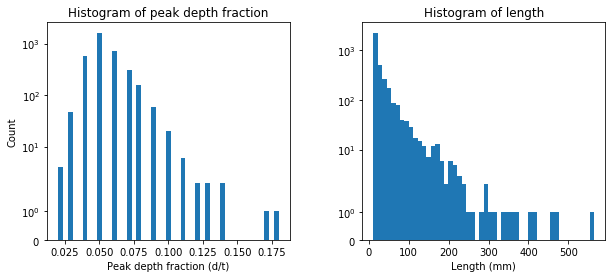

In [143]:
f, axes = plt.subplots(nrows=1, ncols = 2)
f.set_figwidth(10)
plt.subplots_adjust(wspace = 0.3)

#select subplot 1
plt.sca(axes[0])
df.query("ILIFSurfaceInd == 'I' & status == 'Active'").loc[:,'ILIFPeakDepthPct'].plot.hist(bins = 45)
plt.xlabel('Peak depth fraction (d/t)')
plt.ylabel('Count')
plt.yscale('symlog')
axes[0].set_title('Histogram of peak depth fraction')

#select subplot 2
plt.sca(axes[1])
df.query("ILIFSurfaceInd == 'I' & status == 'Active'").loc[:,'ILIFLength'].plot.hist(bins = 50)
plt.xlabel('Length (mm)')
plt.ylabel('')
plt.yscale('symlog')
axes[1].set_title('Histogram of length')


In [144]:
order = ['ILIFPeakDepthPct','ILIFLength','ILIFSurfaceInd','Id',
         'FailureYear','FailureProbability','FailureMode',
         'OutsideDiameter in','NominalWallThickness mm','PipeGrade MPa',
         'MaximumAllowableOperatingPressure kPa',
        'InstallationDate',
        'ILIDate']
comb_r.query("FailureYear >= 0 & status == 'Active'").loc[:,order].to_clipboard()

## EAR FALLS LATERAL SUSCEPTIBILITY ASSESSMENT

In [680]:
allowed = (4.78 - (4200.00*114.3)/(172*2000))

import datetime
i_date = datetime.date(1967,1,1)
a_date = datetime.date.today()

WT_AGE = 4.78/((a_date-i_date).days/365.25)
WT_AGE
print(f"It would take {allowed/WT_AGE:4.2f} years to corrode the pipe wall to an amount equal to the corrosion allowance of {allowed:4.2f}mm, assuming a constant corrosion rate of {WT_AGE:4.2f}mm/year")


It would take 37.31 years to corrode the pipe wall to an amount equal to the corrosion allowance of 3.38mm, assuming a constant corrosion rate of 0.09mm/year


# STRESS CORROSION CRACKING ASSESSMENT

In [151]:
wt = 4.78
OD = 219.075
grade = 172.00
test_pres = [4200.00,6508.0+50.0,6846.57+34.43,6455.64+34.36,6468.29+34.71,6649.68+25.32,6357.05+24.95]
test_pres

pd.DataFrame(test_pres, columns=['Pressure']).assign(StressPCT = lambda x: (x['Pressure']*OD)/(20.0*grade*wt))

,Pressure,StressPCT
0,4200.0,55.9572
1,6558.0,87.3731
2,6881.0,91.6765
3,6490.0,86.4672
4,6503.0,86.6404
5,6675.0,88.9319
6,6382.0,85.0283


Following cell creates a function to classify each anomaly into a metal loss type

In [145]:
def anomaly_type(wt, f):
    a = max(10.0,wt)
    
    anom_criteria = [
            (f.ILIFWidth >= 3*a) & (f.ILIFLength >= 3*a),
           (f.ILIFWidth.ge(a) & f.ILIFWidth.lt(6*a)) & (f.ILIFLength.ge(a) & f.ILIFLength.lt(6*a)) & ((f.ILIFLength/f.ILIFWidth).gt(0.5) & (f.ILIFLength/f.ILIFWidth).lt(2.0)) & ~((f.ILIFWidth >= 3*a) & (f.ILIFLength >= 3*a)),
           (f.ILIFWidth.ge(a) & f.ILIFWidth.lt(3*a)) & ((f.ILIFLength/f.ILIFWidth)>=2.0),
           ((f.ILIFLength/f.ILIFWidth)<=0.5) & (f.ILIFLength.ge(a) & f.ILIFLength.lt(3*a)),
           (f.ILIFWidth.gt(0.0) & f.ILIFWidth.lt(a)) & (f.ILIFLength.gt(0.0) & f.ILIFLength.lt(a)),
            (f.ILIFWidth.gt(0.0) & f.ILIFWidth.lt(a)) & (f.ILIFLength.ge(a)),
           (f.ILIFWidth >= a) & (f.ILIFLength.gt(0.0) & f.ILIFLength.lt(a)),
               ]

    values = ['general',
             'pitting',
             'axial grooving',
             'circumferential grooving',
             'pinhole',
             'axial slotting',
             'circumferential slotting']

    return np.select(anom_criteria, values, default='None')

Following cell applies the classification to the dataframe

In [146]:
df.query("status == 'Active' & ~ILIFComment.str.contains('manufacturing')").loc[:,['ILIFSurfaceInd','section','ILIFPeakDepthPct','ILIFLength','ILIFWidth']].assign(mltype = lambda row: anomaly_type(4.78, row)).groupby(['ILIFSurfaceInd','mltype']).agg({'ILIFPeakDepthPct':'max','section':'count','ILIFLength':'mean','ILIFWidth':'min'})#.query('mltype.str.contains("axi")')

# np.vectorize(anomaly_type)(4.78, df.query("status == 'Active' & ILIFSurfaceInd == 'I'").ILIFLength, df.query("status == 'Active' & ILIFSurfaceInd == 'I'").ILIFWidth)

ILIFPeakDepthPct  section  \
ILIFSurfaceInd mltype                                                
E              axial grooving                        0.24      321   
               circumferential grooving              0.42     1386   
               general                               0.77      917   
               pitting                               0.70     3448   
I              axial grooving                        0.18      545   
               circumferential grooving              0.07       37   
               general                               0.14      381   
               pitting                               0.17     2605   

                                         ILIFLength  ILIFWidth  
ILIFSurfaceInd mltype                                           
E              axial grooving               42.4611       15.0  
               circumferential grooving     19.6025       26.0  
               general                      54.1843       30.0  
               pitting                      19.7320       11.0  
I              axial grooving               50.9321       15.0  
               circumferential grooving     17.2973       25.0  
               general                      96.0892       30.0  
               pitting                      17.0933       15.0

# MANUFACTURING ANOMALY ASSESSMENT
<a id="manu"></a>

* [TOC](#toc)

The following giant cell will attempt to calculate the critical depth using the following 3 approaches:
* NG-18 equation (not working)
* LN-SEC
* MODIFIED-LNSEC

Will need to see if there is a way I can validate these results. Perhaps MAT-8 can do it.

In [193]:
def critical_flaw_size_ng18(le, pdp, od, wt, s, cvn, mop):
##    od, wt, s, cvn, mop, le = x[0], x[1], x[2], x[3], x[4], x[5]

    ##CONSTANTS------------------------------------------
    #young's modulus in psi
    E = 30000000.0
    #fracture area of charpy notch test in in2
    ac=0.124
    #flow stress in psi
    sf = s + 10000

    ##CALCULATIONS------------------------------------------
    #pipe radius in inches
    r = od/2
    #pipe stress from Barlow formula in psi
    stress = (mop*od)/(2*wt)

    ##ITERATION SETUP------------------------------------------
    #assumed 60%wt
#     pdp=0.6

    c2rt= pow(le,2)/(r*wt)
    Mt=math.sqrt(1+1.255*c2rt-0.0135*pow(c2rt,2))
    Mp=(1-(pdp/Mt))/(1-pdp)

    #error function
    e = abs(le - ((12*cvn*E*math.pi)/(ac*8*pow(sf,2)))*pow(math.log(1/math.cos((math.pi*Mp*stress)/(2*sf))),-1))

    return e


def critical_flaw_size_lnsec(le, pdp, od, wt, s, cvn, mop):
##    od, wt, s, cvn, mop, le = x[0], x[1], x[2], x[3], x[4], x[5]

    ##CONSTANTS------------------------------------------
    #young's modulus in psi
    E = 30000000.0
    #fracture area of charpy notch test in in2
    ac=0.124
    #flow stress in psi
    sf = s + 10000

    ##CALCULATIONS------------------------------------------
    #pipe radius in inches
    r = od/2
    #pipe stress from Barlow formula in psi
    stress = (mop*od)/(2*wt)

    ##ITERATION SETUP------------------------------------------
    #assumed 60%wt
#     pdp=0.6

    elliptical_c = min(math.pi*le*0.25,math.sqrt(67.2*r*wt))
    c2rt= pow(elliptical_c,2)/(r*wt)

    Mt=max(math.sqrt(1+1.255*c2rt-0.0135*pow(c2rt,2)),pdp+0.001)
    Mp=(1-(pdp/Mt))/(1-pdp)
    XP = (12*E*math.pi*cvn)/(8*elliptical_c*ac*pow(sf,2))
    fail_stress = (sf/Mp)*math.acos(math.exp(-1*XP))

    e = abs(fail_stress - stress)
    
    return e

def lnsec(od, wt, s, cvn, mop, pdp, le):
    '''
    Modified ln-sec formula calculation
    
    @param od: outside diameter in inch.
    @param wt: wall thickness in inch.
    @param s: grade in psi.
    @param cvn: charpy toughness in ft-lbs.
    @param mop: maximum operating pressure in psi.
    @param pdp: peak depth percentage in fraction of wt.
    @param le: length of crack imperfection in inch.
    '''
    ##CONSTANTS------------------------------------------
    #young's modulus in psi
    E = 30000000.0
    #fracture area of charpy notch test in in2
    ac=0.124
    #flow stress in psi
    sf = s + 10000

    ##CALCULATIONS------------------------------------------
    #pipe radius in inches
    r = od/2
    #pipe stress from Barlow formula in psi
    stress = (mop*od)/(2*wt)

    elliptical_c = min(math.pi*le*0.25,math.sqrt(67.2*r*wt))
    c2rt= pow(elliptical_c,2)/(r*wt)

    Mt=max(math.sqrt(1+1.255*c2rt-0.0135*pow(c2rt,2)),pdp+0.001)
    Mp=(1-(pdp/Mt))/(1-pdp)
    XP = (12*E*math.pi*cvn)/(8*elliptical_c*ac*pow(sf,2))
    fail_stress = (sf/Mp)*math.acos(math.exp(-1*XP))

    if (fail_stress <= stress):
        fail_flag = 'FAIL'
    else:
        fail_flag = 'PASS'
    
    return stress, fail_stress, fail_flag


def critical_flaw_size_modlnsec(le, pdp, od, wt, s, cvn, mop):
##    od, wt, s, cvn, mop, le = x[0], x[1], x[2], x[3], x[4], x[5]

    ##CONSTANTS------------------------------------------
    #young's modulus in psi
    E = 30000000.0
    #fracture area of charpy notch test in in2
    ac=0.124
    #flow stress in psi
    sf = s + 10000

    ##CALCULATIONS------------------------------------------
    #pipe radius in inches
    r = od/2
    #pipe stress from Barlow formula in psi
    stress = (mop*od)/(2*wt)

    ##ITERATION SETUP------------------------------------------
    #assumed 60%wt
#     pdp=0.6

    elliptical_c = min(math.pi*le*0.25,math.sqrt(67.2*r*wt))
    c2rt= pow(elliptical_c,2)/(r*wt)

    Mt=max(math.sqrt(1+1.255*c2rt-0.0135*pow(c2rt,2)),pdp+0.001)
    Mp=(1-(pdp/Mt))/(1-pdp)
    XP = (12*E*math.pi*cvn)/(8*elliptical_c*ac*pow(sf,2))
    YP = XP*pow(1-pow(pdp,0.8),-1)
    fail_stress = (sf/Mp)*math.acos(math.exp(-1*XP))/math.acos(math.exp(-1*YP))

    e = abs(fail_stress - stress)
    
    return e

def modlnsec(od, wt, s, cvn, mop, pdp, le):
    '''
    Modified ln-sec formula calculation
    
    @param od: outside diameter in inch.
    @param wt: wall thickness in inch.
    @param s: grade in psi.
    @param cvn: charpy toughness in ft-lbs.
    @param mop: maximum operating pressure in psi.
    @param pdp: peak depth percentage in fraction of wt.
    @param le: length of crack imperfection in inch.
    '''
    ##CONSTANTS------------------------------------------
    #young's modulus in psi
    E = 30000000.0
    #fracture area of charpy notch test in in2
    ac=0.124
    #flow stress in psi
    sf = s + 10000

    ##CALCULATIONS------------------------------------------
    #pipe radius in inches
    r = od/2
    #pipe stress from Barlow formula in psi
    stress = (mop*od)/(2*wt)

    elliptical_c = min(math.pi*le*0.25,math.sqrt(67.2*r*wt))
    c2rt= pow(elliptical_c,2)/(r*wt)

    Mt=max(math.sqrt(1+1.255*c2rt-0.0135*pow(c2rt,2)),pdp+0.001)
    Mp=(1-(pdp/Mt))/(1-pdp)
    XP = (12*E*math.pi*cvn)/(8*elliptical_c*ac*pow(sf,2))
    YP = XP*pow(1-pow(pdp,0.8),-1)
    fail_stress = (sf/Mp)*math.acos(math.exp(-1*XP))/math.acos(math.exp(-1*YP))

    if (fail_stress <= stress):
        fail_flag = 'FAIL'
    else:
        fail_flag = 'PASS'
    
    return stress, fail_stress, fail_flag


In [215]:
input_data = (0.4, 12.75,4.78/25.4,(172*1000)/6.89476,10/1.3558,5900/6.89476)
display(input_data[5])
# display(optimize.minimize(critical_flaw_size_ng18,0.1,args=input_data, method='nelder-mead').x)
display(optimize.minimize(critical_flaw_size_lnsec,0.1,args=input_data, method='nelder-mead').x)
display(optimize.minimize(critical_flaw_size_modlnsec,0.1,args=input_data, method='nelder-mead').x)

855.7223166578677

array([7.18011414])

array([1.30102585])

In [152]:
np.unique(df.ILIFComment.values)

array(['CLUSTER', 'CLUSTER / on bend', 'CLUSTER / on dent',
       'CLUSTER / under casing', 'metal loss corrosion',
       'metal loss corrosion / dent in proximity',
       'metal loss corrosion / on casing',
       'metal loss corrosion / on dent',
       'metal loss corrosion / on minor ID reduction',
       'metal loss corrosion / under casing',
       'metal loss girth weld anomaly',
       'metal loss manufacturing anomaly',
       'metal loss manufacturing anomaly / on minor ID reduction',
       'metal loss manufacturing anomaly / possible debris'], dtype=object)

Plotting the distribution of depth and length of metal loss manufacturing features

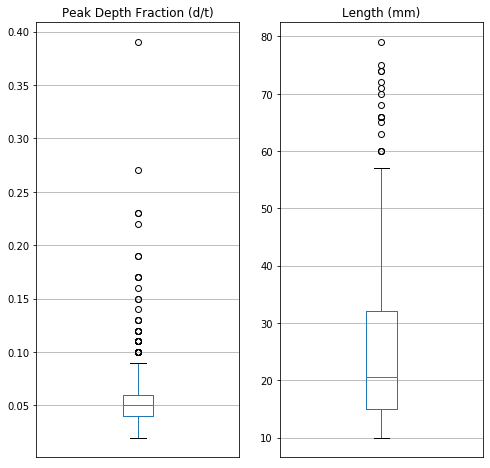

In [153]:
ax = df.query("ILIFComment.str.contains('manufacturing')").loc[:,['ILIFPeakDepthPct','ILIFLength']].plot(kind='box',
                                                                                                    subplots=True,
                                                                                                   grid=True,
                                                                                                   figsize=(8,8),
                                                                                                   title=['Peak Depth Fraction (d/t)','Length (mm)'])
plt.subplots_adjust(wspace = 0.2,hspace=0)
ax[0].axes.get_xaxis().set_visible(False)
ax[1].axes.get_xaxis().set_visible(False)

In [154]:
np.unique(ncd.ILINCDComment.values)

array(['Deformation / Dent Depth: 1.3% possible wrinkle',
       'Deformation / Dent Depth: 1.4% possible wrinkle',
       'Deformation / Dent Depth: 1.7% wrinkle',
       'Deformation / Dent Depth: 2.2% possible wrinkle',
       'Deformation-detected with metal loss / Dent Depth: 0.5%',
       'Deformation-detected with metal loss / Dent Depth: 0.6% dents in proximity',
       'Deformation-detected with metal loss / Dent Depth: 0.7%',
       'Deformation-detected with metal loss / Dent Depth: 1.0%',
       'Deformation-detected with metal loss / Dent Depth: 1.1%',
       'Deformation-detected with metal loss / Dent Depth: 1.1% close to weld',
       'Deformation-detected with metal loss / Dent Depth: 1.7%',
       'Deformation-detected with metal loss / Dent Depth: 2.0% PR',
       'Deformation-detected with metal loss / Dent Depth: 3.8% PR channeling metal los',
       'Deformation-detected with metal loss / Dent Depth: 6.2% PR',
       'Deformation-detected with metal loss / Dent De

In [155]:
ncd.query("ILINCDComment.str.contains('manufacturing')").describe().loc[:,:]

,Id,InlineInspectionRangeId,ILINCDTypeDomainId,ILINCDStatusDomainId,ILINCDOdometer,ILINCDLength,ILINCDWidth,ILINCDOrientation,ILINCDDepthPct,ILINCDDepthPctNPS,ILINCDDistanceFromGirthWeld,ILINCDGrading1DomainId,ILINCDGrading2DomainId,ILINCDStrain,ILINCDDistanceFromGirthWeldDS,ILINCDLatitude,ILINCDLongitude,ILINCDX,ILINCDY,ILINCDZ,StationSeriesId,StationNum,BeginStationSeriesId,BeginStationNum,EndStationSeriesId,EndStationNum
count,138.0000,138.0,138.0,138.0,138.0000,138.0000,138.0000,138.0000,0.0,0.0,138.0000,138.0,138.0,138.0,138.0000,138.0000,138.0000,138.0000,1.3800e+02,138.0000,138.0,138.0000,138.0,138.0000,138.0,138.0000
mean,2720.9275,32.0,600269.0,10143.0,67616.4373,25.2754,17.4855,169.6957,NaN,NaN,5.8199,26932.0,26933.0,0.0,8.8831,50.3663,-93.2500,482220.0797,5.5794e+06,376.1055,2.0,67616.4373,2.0,67616.4373,2.0,67616.4373
std,356.5247,0.0,0.0,0.0,35453.3723,20.8357,6.4335,83.6855,NaN,NaN,4.5936,0.0,0.0,0.0,4.7381,0.2648,0.0824,5836.5798,2.9451e+04,19.8551,0.0,35453.3723,0.0,35453.3723,0.0,35453.3723
min,2184.0000,32.0,600269.0,10143.0,282.8430,6.0000,5.0000,5.0000,NaN,NaN,0.1860,26932.0,26933.0,0.0,0.0790,49.8596,-93.4068,471301.3530,5.5231e+06,344.9620,2.0,282.8430,2.0,282.8430,2.0,282.8430
25%,2402.5000,32.0,600269.0,10143.0,37342.8068,12.0000,15.0000,119.5000,NaN,NaN,1.2548,26932.0,26933.0,0.0,4.8860,50.1422,-93.2836,479762.2290,5.5545e+06,363.9452,2.0,37342.8068,2.0,37342.8068,2.0,37342.8068
50%,2678.5000,32.0,600269.0,10143.0,61754.9865,16.5000,15.0000,167.5000,NaN,NaN,5.4500,26932.0,26933.0,0.0,8.9650,50.3236,-93.2567,481647.5850,5.5746e+06,369.8085,2.0,61754.9865,2.0,61754.9865,2.0,61754.9865
75%,3037.7500,32.0,600269.0,10143.0,103600.3132,32.0000,15.0000,216.0000,NaN,NaN,9.5575,26932.0,26933.0,0.0,13.5213,50.6361,-93.2051,485360.8868,5.6094e+06,385.1008,2.0,103600.3132,2.0,103600.3132,2.0,103600.3132
max,3448.0000,32.0,600269.0,10143.0,126092.6460,182.0000,46.0000,359.0000,NaN,NaN,15.2350,26932.0,26933.0,0.0,15.2060,50.8024,-93.0945,493288.7160,5.6279e+06,453.3620,2.0,126092.6460,2.0,126092.6460,2.0,126092.6460


TypeError: only list-like or dict-like objects are allowed to be passed to DataFrame.isin(), you passed a 'float64'

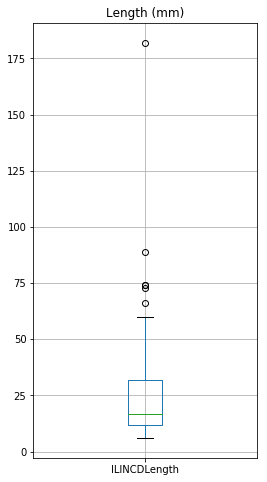

In [156]:
ncd_p = ncd.query("ILINCDComment.str.contains('manufacturing')").loc[:,['ILINCDLength']]
ax2 = ncd_p.plot(kind='box',
               grid=True,
               figsize=(4,8),
               title='Length (mm)')

for i,each in enumerate(ncd_p.index):
#     if ncd_p.describe().isin(ncd_p.loc[each,:].values[0]).any().values[0]:
    if ncd_p.isin(ncd_p.loc[each,:].values[0]).any().describe().values[0]:
        y = ncd_p.loc[each,:].values[0]
        ax2.text(1,y,y)

ax2.axes.get_xaxis().set_visible(False)

In [51]:
ncd_p.loc[1132,:].values[0]

10.0

# DEFORMATION AND DENT ASSESSMENT
<a id="third"></a>

* [TOC](#toc)

Identifying in which test section these ncd anomalies are located

In [216]:
'''t_s_1 = (0.,19731.)
t_s_2 = (19731.,44527.58)
t_s_3 = (44527.58,65578.5)
t_s_4 = (65578.5,82142.)
t_s_5 = (82142.,110914.7)
t_s_6 = (110914.7,130000)
'''

ncd.set_index('BeginStationNum', inplace=True)
ncd.sort_index(inplace=True)

criteria_ncd = [ncd.index.to_series().between(t_s_1[0],t_s_1[1]),
           ncd.index.to_series().between(t_s_2[0],t_s_2[1]),
           ncd.index.to_series().between(t_s_3[0],t_s_3[1]),
           ncd.index.to_series().between(t_s_4[0],t_s_4[1]),
           ncd.index.to_series().between(t_s_5[0],t_s_5[1]),
           ncd.index.to_series().between(t_s_6[0],t_s_6[1])]

values = ['test section 1',
         'test section 2',
         'test section 3',
         'test section 4',
         'test section 5',
         'test section 6']

ncd['section'] = np.select(criteria_ncd, values, 0)

In [217]:
ncd.groupby('type')['Id'].count()


type
Dent                        1110
Dent w/ Metal Loss            13
Extra Metal                    7
Manufacturing Indication     138
Weld anomaly                   1
Name: Id, dtype: int64

* Seems the Extra Metal anomalies are non-issue.
* The Manufacturing Indication have been looked at in the Manufacturing defects section
* For deformation and dent assessment, will only concentrate on Dent and Dent w/ Metal Loss
* should look at  the Weld anomaly within the CT section, since the comment states it is a girth weld anomaly

Creating a subset of data, only looking at deformations or dents

In [218]:
dents = ncd.query('type == "Dent" or type == "Dent w/ Metal Loss"')

In [219]:
dents.loc[:,['ILINCDLength','ILINCDWidth','ILINCDDepthPct','ILINCDDepthPctNPS']].describe()

,ILINCDLength,ILINCDWidth,ILINCDDepthPct,ILINCDDepthPctNPS
count,1123.0000,1123.0000,13.0000,1123.0000
mean,178.5637,95.4889,0.0692,0.0173
std,88.4447,25.8818,0.0350,0.0159
min,35.0000,36.0000,0.0400,0.0050
25%,122.0000,76.0000,0.0500,0.0080
50%,164.0000,97.0000,0.0600,0.0110
75%,213.5000,115.0000,0.0700,0.0180
max,846.0000,271.0000,0.1700,0.1130


In [220]:
joint.head()
crossing.head()

,type,CrossingName,CrossingComment,CrossingWidth,CrossingId,StationSeriesId,EffectiveStartDate,EffectiveEndDate,CrossingLocnLatitude,CrossingLocnLongitude,CrossingLocnCoordSysDomainId,CrossingLocnX,CrossingLocnY,CrossingLocnZ,CrossingLocnEngineeringStnFlg,LastModByUserId,LastModDateTime,BeginStationSeriesId,BeginStationNum,EndStationSeriesId,EndStationNum,SourceId,CreatedDate,CreatedUser,section
StationNum,,,,,,,,,,,,,,,,,,,,,,,,,
2456.6205,Trail,Gravel Driveway,Gravel Driveway,43.139,344.0,2.0,2019-06-26,NaT,None,None,26916.0,None,None,None,None,DYNAMIC_RISK\Vincent_Soo,2019-06-26,2.0,2435.051,2.0,2478.190,None,2019-06-26 10:15:07.387,DYNAMIC_RISK\vincent_soo,test section 1
2678.1750,Highway,HWY 105,HWY 105,76.455,345.0,2.0,2019-06-26,NaT,None,None,26916.0,None,None,None,None,DYNAMIC_RISK\Vincent_Soo,2019-06-26,2.0,2639.947,2.0,2716.403,None,2019-06-26 10:15:07.450,DYNAMIC_RISK\vincent_soo,test section 1
4052.0300,Road,Ellek Road,Ellek Road,44.076,346.0,2.0,2019-06-26,NaT,None,None,26916.0,None,None,None,None,DYNAMIC_RISK\Vincent_Soo,2019-06-26,2.0,4029.992,2.0,4074.068,None,2019-06-26 10:15:07.450,DYNAMIC_RISK\vincent_soo,test section 1
4722.7115,Road,Ellek Road,Ellek Road,75.018,347.0,2.0,2019-06-26,NaT,None,None,26916.0,None,None,None,None,DYNAMIC_RISK\Vincent_Soo,2019-06-26,2.0,4685.202,2.0,4760.221,None,2019-06-26 10:15:07.450,DYNAMIC_RISK\vincent_soo,test section 1
6017.0710,Highway,HWY 105,HWY 105,37.814,348.0,2.0,2019-06-26,NaT,None,None,26916.0,None,None,None,None,DYNAMIC_RISK\Vincent_Soo,2019-06-26,2.0,5998.164,2.0,6035.978,None,2019-06-26 10:15:07.467,DYNAMIC_RISK\vincent_soo,test section 1


Calculates dent strain according to ASME B31.8 Appendix R

In [335]:
OD = 8.625*25.4
print(OD)

def dent_str(wt,od,dnps,l,w):
    d = dnps*od
    cbstr = (wt/2)*((2/od)-(-1/((d**2+(w/2)**2)/(2*d))))
    lbstr = (wt/2)*(1/((d**2+(l/2)**2)/(2*d)))
    lestr = 0.5*(d/l)**2
    inside_str = (cbstr**2 - cbstr*(lbstr+lestr) + (lbstr+lestr)**2)**0.5
    outsid_str = (cbstr**2 + cbstr*(-lbstr+lestr) + (-lbstr+lestr)**2)**0.5
    maxstr = pd.DataFrame([cbstr, lbstr, lestr, inside_str, outsid_str]).max()
    return maxstr

dent_str(4.78,OD,0.009,143.0,117.0)
# dent_str(4.78,OD,dents.ILINCDDepthPctNPS,dents.ILINCDLength,dents.ILINCDWidth)

219.075


0    0.0246
dtype: float64

The following cell is setup to run CSA Z662 Clause 10 and Union Gas P201 criteria

In [336]:
# crit =("10.10.4.2a)i)","actual_d >= 6.0 & WELD_INTERACT==True")
# crit =("10.10.4.2b)","ILINCDDepthPctNPS>0.06")
# crit =("10.10.4.2c)/D2SHP.1", "(LbD<20)")
crit =("10.10.4.2f)/D2RSC", "ILINCDComment.str.contains('wrinkle') & ~ILINCDComment.str.contains('possible')")
# crit =("D1ML10", "ILINCDDepthPctNPS>=0.02 & ILINCDDepthPct>=0.10")
# crit =("D2D6", "ILINCDDepthPctNPS>0.06")
# crit =("D2XNG", "CROSSING_INTERACT==True") #THIS CONDITION NEEDS A MORE DETAILED LOOK
# crit =("D2SHP.2", "LbD<20 & WELD_INTERACT==True")

dents.loc[:,'actual_d'] = dents.loc[:,'ILINCDDepthPctNPS']*OD
gwd = ['ILINCDFeatureNumber','ILINCDComment','ILINCDDepthPct','actual_d','ILINCDDepthPctNPS','ILINCDLength','ILINCDWidth','ILINCDDistanceFromGirthWeld','ILINCDDistanceFromGirthWeldDS','orientation']

dent_assessment = dents.loc[:,gwd].assign(dSTART=dents.ILINCDOdometer, #start of dent
                        dEND=dents.ILINCDOdometer+dents.ILINCDLength/1000, #end of dent 
                        INTERACT_DS=lambda x: x['dEND']-dents.ILINCDOdometer+dents.ILINCDDistanceFromGirthWeldDS, #checks interaction wth downstream girthweld
                        #lambda x allows addressing of other assign columns
                        #lamba z dives into each row of the dataframe, and checks whether the dSTART and dEND ranges cover any girth weld, US or DS
                        #axis = 1 is required within the .apply() in order to check across columns
                        WELD_INTERACT=lambda x: x.loc[:,['dSTART','dEND']].apply(lambda z: joint.index.to_series().between(z[0],z[1]).any(), axis=1),
                        CROSSING_INTERACT=lambda x: x.loc[:,['dSTART','dEND']].apply(lambda z: crossing.BeginStationNum.between(z[0],z[1]).any() | crossing.EndStationNum.between(z[0],z[1]).any(), axis=1),
                        dSTR= lambda x: dent_str(4.78,OD,x.ILINCDDepthPctNPS,x.ILINCDLength,x.ILINCDWidth),
                       LbD = dents.ILINCDLength/(dents.ILINCDDepthPctNPS*OD)).query(crit[1])

display(dent_assessment.count()['ILINCDFeatureNumber'])
display(dent_assessment)
# dent_assessment.count()
dent_assessment.to_clipboard()

1

,ILINCDFeatureNumber,ILINCDComment,ILINCDComment,ILINCDDepthPct,actual_d,ILINCDDepthPctNPS,ILINCDLength,ILINCDWidth,ILINCDDistanceFromGirthWeld,ILINCDDistanceFromGirthWeldDS,orientation,dSTART,dEND,INTERACT_DS,WELD_INTERACT,CROSSING_INTERACT,dSTR,LbD
BeginStationNum,,,,,,,,,,,,,,,,,,
44593.607,114053,Deformation / Dent Depth: 1.7% wrinkle,Deformation / Dent Depth: 1.7% wrinkle,NaN,3.7243,0.017,332.0,152.0,7.799,6.911,NaN,44593.607,44593.939,7.243,False,False,0.0249,89.1449


Following cell performs some complicated joins to find the dents within each crossing(begin_station,end_station)

In [244]:
# cover_depth.loc[:,['section','CoverDepthReading']].assign(CROSSING_INTERACT= lambda x: crossing.loc[:,'type'].where(x.index.to_series().between(crossing.BeginStationNum,crossing.EndStationNum)).any(), axis=1)

dents['Chainage'] = dents.index

temp_dt = dents.index.to_series().values
temp_croB = crossing.BeginStationNum.values
temp_croE = crossing.EndStationNum.values

ind_i, ind_j = np.where((temp_dt[:,None] >= temp_croB) & (temp_dt[:,None] <= temp_croE))

#need to understand this next statement a little more
temp_dt_result = pd.DataFrame(np.column_stack([dents.values[ind_i], crossing.values[ind_j]]),
                columns=dents.columns.append(crossing.columns))

temp_dt_result.set_index('Chainage',inplace=True)
temp_dt_result.sort_index(inplace=True)
temp_dt_result = temp_dt_result.loc[:,~temp_dt_result.columns.duplicated()]
queried_results = temp_dt_result.query("(ILINCDOrientation>=240 | ILINCDOrientation<=120)").loc[:,['section','CrossingId','crossing_type','ILINCDFeatureNumber','type','ILINCDDepthPctNPS','ILINCDOrientation']].query("~crossing_type.str.contains('Overhead Power Line') & ~crossing_type.str.contains('UNDETERMINED')")
grouped_dt_results = queried_results.groupby(['section','CrossingId','crossing_type']).ILINCDDepthPctNPS.agg(['count','max'])
grouped_dt_results
# temp_result.type.unique()#.query("~type.str.contains('overhead') or ~type.str.contains('undertermine')")

C:\Python36\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


count    max
section        CrossingId crossing_type              
test section 1 351.0      River              1  0.009
               352.0      River              2  0.019
               353.0      Highway            1  0.016
               355.0      Railroad           1  0.014
               357.0      River              4  0.019
test section 2 367.0      Highway            4  0.013
               368.0      Trail              1  0.029
               369.0      Highway            3  0.075
               376.0      Highway            1  0.012
test section 3 390.0      Highway            1  0.009
               392.0      Trail              1  0.011
               397.0      Trail              1  0.035
               398.0      Trail              2  0.011
test section 4 408.0      Trail              1  0.016
test section 5 413.0      River              2  0.020
               414.0      River              1  0.018
               415.0      River              1  0.008
               416.0      Highway            1  0.018
               418.0      Railroad           1  0.027
               420.0      Trail              1  0.008
               424.0      Railroad           1  0.013
               425.0      Highway            1  0.008
               436.0      Trail              1  0.034
test section 6 438.0      River              2  0.009
               443.0      Highway            1  0.009
               444.0      River              1  0.012
               446.0      Trail              2  0.009
               447.0      River              1  0.009

In [245]:
queried_results

,section,CrossingId,crossing_type,ILINCDFeatureNumber,type,ILINCDDepthPctNPS,ILINCDOrientation
Chainage,,,,,,,
9038.733,test section 1,351,River,113675,Dent,0.009,303
9808.943,test section 1,352,River,113686,Dent,0.019,309
9822.957,test section 1,352,River,113687,Dent,0.016,302
12258.185,test section 1,353,Highway,113707,Dent,0.016,324
14916.864,test section 1,355,Railroad,113735,Dent,0.014,21
16791.048,test section 1,357,River,113760,Dent,0.006,304
16795.083,test section 1,357,River,113761,Dent,0.008,317
16797.422,test section 1,357,River,113762,Dent,0.019,348
16798.515,test section 1,357,River,113763,Dent w/ Metal Loss,0.005,327


Proof:

In [227]:
crossing.query("CrossingId == 369")

,type,CrossingName,CrossingComment,CrossingWidth,CrossingId,StationSeriesId,EffectiveStartDate,EffectiveEndDate,CrossingLocnLatitude,CrossingLocnLongitude,CrossingLocnCoordSysDomainId,CrossingLocnX,CrossingLocnY,CrossingLocnZ,CrossingLocnEngineeringStnFlg,LastModByUserId,LastModDateTime,BeginStationSeriesId,BeginStationNum,EndStationSeriesId,EndStationNum,SourceId,CreatedDate,CreatedUser,section
StationNum,,,,,,,,,,,,,,,,,,,,,,,,,
34530.158,Highway,HWY 105,HWY 105,81.256,369.0,2.0,2019-06-26,NaT,None,None,26916.0,None,None,None,None,DYNAMIC_RISK\Vincent_Soo,2019-06-26,2.0,34489.53,2.0,34570.786,None,2019-06-26 10:15:07.573,DYNAMIC_RISK\vincent_soo,test section 2


In [383]:
dents.loc[dents.index.to_series().gt(2639.947) & (dents.index.to_series()+dents.ILINCDLength/1000).lt(2716.403)]

,status,type,ILINCDComment,Id,EffectiveStartDate,EffectiveEndDate,InlineInspectionRangeId,ILINCDTypeDomainId,ILINCDStatusDomainId,ILINCDOdometer,ILINCDFeatureNumber,ILINCDLength,ILINCDWidth,ILINCDOrientation,ILINCDDepthPct,ILINCDDepthPctNPS,ILINCDGirthWeldNum,ILINCDDistanceFromGirthWeld,ILINCDComment,ILINCDGrading1DomainId,ILINCDGrading2DomainId,ILINCDResponseTime,ILINCDStrain,ILINCDVendorPackageCode,ILINCDGirthWeldNumDS,ILINCDDistanceFromGirthWeldDS,ILINCDSurfaceInd,CFRGrading1DomainID,CFRGrading2DomainID,ILINCDLatitude,ILINCDLongitude,ILINCDCoordSysDomainId,ILINCDX,ILINCDY,ILINCDZ,StationSeriesId,StationNum,LastModByUserId,LastModDateTime,CalcLatitude,CalcLongitude,UpdateAudit,DscvryDt,UpdtDscvryDt,OperatorComment,DscvryDtUpdReasonDomainId,SentencedResponseTime,BeginStationSeriesId,EndStationSeriesId,EndStationNum,SourceId,CreatedDate,CreatedUser,InlineInspectionId,section,Chainage
BeginStationNum,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2653.677,Active,Dent,Dent / Dent Depth: 0.9%,3423.0,2019-06-17 10:32:54,None,32.0,600222.0,10143.0,2653.677,113606,169.0,115.0,231.0,NaN,0.009,1970,14.801,Dent / Dent Depth: 0.9%,26932.0,26933.0,None,0.0,None,1980,0.665,U,None,None,49.8797,-93.3595,None,474171.818,5.5253e+06,360.518,2.0,2653.677,DYNAMIC_RISK\vincent_soo,2019-06-17 11:02:44.913,None,None,None,None,None,None,None,None,2.0,2.0,2653.677,None,2019-06-17 11:02:44.913,DYNAMIC_RISK\vincent_soo,None,test section 1,2653.677
2686.721,Active,Dent,Dent / Dent Depth: 0.5%,3422.0,2019-06-17 10:32:54,None,32.0,600222.0,10143.0,2686.721,113607,76.0,78.0,148.0,NaN,0.005,2000,2.247,Dent / Dent Depth: 0.5%,26932.0,26933.0,None,0.0,None,2010,13.132,U,None,None,49.8797,-93.3590,None,474204.660,5.5253e+06,357.209,2.0,2686.721,DYNAMIC_RISK\vincent_soo,2019-06-17 11:02:44.913,None,None,None,None,None,None,None,None,2.0,2.0,2686.721,None,2019-06-17 11:02:44.913,DYNAMIC_RISK\vincent_soo,None,test section 1,2686.721


# SURFACE LOADING ASSESSMENT

This section will take the depth of cover profile for the pipeline in question, classify it on a per test section location, and determine whether any of the points are below the minimum required depth of cover.

Additionally, the crossings information will be categorized on a per test section basis as well, in order to determine how many crossings per test section.

In [246]:
'''t_s_1 = (0.,19731.)
t_s_2 = (19731.,44527.58)
t_s_3 = (44527.58,65578.5)
t_s_4 = (65578.5,82142.)
t_s_5 = (82142.,110914.7)
t_s_6 = (110914.7,130000)
'''

criteria_doc = [cover_depth.index.to_series().between(t_s_1[0],t_s_1[1]),
           cover_depth.index.to_series().between(t_s_2[0],t_s_2[1]),
           cover_depth.index.to_series().between(t_s_3[0],t_s_3[1]),
           cover_depth.index.to_series().between(t_s_4[0],t_s_4[1]),
           cover_depth.index.to_series().between(t_s_5[0],t_s_5[1]),
           cover_depth.index.to_series().between(t_s_6[0],t_s_6[1])]

values = ['test section 1',
         'test section 2',
         'test section 3',
         'test section 4',
         'test section 5',
         'test section 6']
cover_depth['section'] = np.select(criteria_doc, values, 0)

In [247]:
cover_depth.head()

,Id,EffectiveStartDate,EffectiveEndDate,CoverDepthReading,Latitude,Longitude,CoordSysDomainId,CoverDepthProfileComment,StationSeriesId,LastModByUserId,LastModDateTime,section,Chainage
StationNum,,,,,,,,,,,,,
24.715,1.0,2019-08-01,None,2.8684,49.8574,-93.3649,26916.0,None,2.0,DYNAMIC_RISK\vincent_soo,2019-08-01 11:39:40.267,test section 1,24.715
30.637,2.0,2019-08-01,None,2.3284,49.8574,-93.3650,26916.0,None,2.0,DYNAMIC_RISK\vincent_soo,2019-08-01 11:39:40.313,test section 1,30.637
37.941,3.0,2019-08-01,None,1.3784,49.8575,-93.3650,26916.0,None,2.0,DYNAMIC_RISK\vincent_soo,2019-08-01 11:39:40.313,test section 1,37.941
48.329,4.0,2019-08-01,None,1.5584,49.8576,-93.3650,26916.0,None,2.0,DYNAMIC_RISK\vincent_soo,2019-08-01 11:39:40.313,test section 1,48.329
57.066,5.0,2019-08-01,None,1.5384,49.8577,-93.3650,26916.0,None,2.0,DYNAMIC_RISK\vincent_soo,2019-08-01 11:39:40.313,test section 1,57.066


In [248]:
'''t_s_1 = (0.,19731.)
t_s_2 = (19731.,44527.58)
t_s_3 = (44527.58,65578.5)
t_s_4 = (65578.5,82142.)
t_s_5 = (82142.,110914.7)
t_s_6 = (110914.7,130000)
'''

criteria_cros = [crossing.index.to_series().between(t_s_1[0],t_s_1[1]),
           crossing.index.to_series().between(t_s_2[0],t_s_2[1]),
           crossing.index.to_series().between(t_s_3[0],t_s_3[1]),
           crossing.index.to_series().between(t_s_4[0],t_s_4[1]),
           crossing.index.to_series().between(t_s_5[0],t_s_5[1]),
           crossing.index.to_series().between(t_s_6[0],t_s_6[1])]

values = ['test section 1',
         'test section 2',
         'test section 3',
         'test section 4',
         'test section 5',
         'test section 6']
crossing['section'] = np.select(criteria_cros, values, 0)

In [249]:
crossing.head()

,crossing_type,CrossingName,CrossingComment,CrossingWidth,CrossingId,StationSeriesId,EffectiveStartDate,EffectiveEndDate,CrossingLocnLatitude,CrossingLocnLongitude,CrossingLocnCoordSysDomainId,CrossingLocnX,CrossingLocnY,CrossingLocnZ,CrossingLocnEngineeringStnFlg,LastModByUserId,LastModDateTime,BeginStationSeriesId,BeginStationNum,EndStationSeriesId,EndStationNum,SourceId,CreatedDate,CreatedUser,section
StationNum,,,,,,,,,,,,,,,,,,,,,,,,,
2456.6205,Trail,Gravel Driveway,Gravel Driveway,43.139,344.0,2.0,2019-06-26,NaT,None,None,26916.0,None,None,None,None,DYNAMIC_RISK\Vincent_Soo,2019-06-26,2.0,2435.051,2.0,2478.190,None,2019-06-26 10:15:07.387,DYNAMIC_RISK\vincent_soo,test section 1
2678.1750,Highway,HWY 105,HWY 105,76.455,345.0,2.0,2019-06-26,NaT,None,None,26916.0,None,None,None,None,DYNAMIC_RISK\Vincent_Soo,2019-06-26,2.0,2639.947,2.0,2716.403,None,2019-06-26 10:15:07.450,DYNAMIC_RISK\vincent_soo,test section 1
4052.0300,Road,Ellek Road,Ellek Road,44.076,346.0,2.0,2019-06-26,NaT,None,None,26916.0,None,None,None,None,DYNAMIC_RISK\Vincent_Soo,2019-06-26,2.0,4029.992,2.0,4074.068,None,2019-06-26 10:15:07.450,DYNAMIC_RISK\vincent_soo,test section 1
4722.7115,Road,Ellek Road,Ellek Road,75.018,347.0,2.0,2019-06-26,NaT,None,None,26916.0,None,None,None,None,DYNAMIC_RISK\Vincent_Soo,2019-06-26,2.0,4685.202,2.0,4760.221,None,2019-06-26 10:15:07.450,DYNAMIC_RISK\vincent_soo,test section 1
6017.0710,Highway,HWY 105,HWY 105,37.814,348.0,2.0,2019-06-26,NaT,None,None,26916.0,None,None,None,None,DYNAMIC_RISK\Vincent_Soo,2019-06-26,2.0,5998.164,2.0,6035.978,None,2019-06-26 10:15:07.467,DYNAMIC_RISK\vincent_soo,test section 1


In [250]:
cover_depth.loc[:,['section','CoverDepthReading']].groupby('section').agg(['min','max','mean',np.std])

CoverDepthReading                         
                             min      max    mean     std
section                                                  
test section 1            0.0000  11.7784  1.1837  0.3957
test section 2            0.2884  12.0784  1.2128  0.3564
test section 3            0.1684   4.4984  1.1350  0.2902
test section 4            0.0384   2.8584  1.0253  0.2033
test section 5           -0.0916  11.4084  1.1131  0.3204
test section 6            0.4484   4.3884  1.1424  0.2367

In [251]:
cover_depth.loc[cover_depth.index.to_series().between(2435.051,2478.190),['section','CoverDepthReading']]

,section,CoverDepthReading
StationNum,,
2437.599,test section 1,1.4084
2443.884,test section 1,1.2384
2451.482,test section 1,1.3584
2455.122,test section 1,1.2284
2461.656,test section 1,1.2384
2468.859,test section 1,1.1084
2475.838,test section 1,1.0884


Following cell performs some complicated joins to find the readings within each crossing

In [684]:
# cover_depth.loc[:,['section','CoverDepthReading']].assign(CROSSING_INTERACT= lambda x: crossing.loc[:,'type'].where(x.index.to_series().between(crossing.BeginStationNum,crossing.EndStationNum)).any(), axis=1)

cover_depth['Chainage'] = cover_depth.index

temp_cd = cover_depth.index.to_series().values
temp_croB = crossing.BeginStationNum.values
temp_croE = crossing.EndStationNum.values

ind_i, ind_j = np.where((temp_cd[:,None] >= temp_croB) & (temp_cd[:,None] <= temp_croE))

temp_result = pd.DataFrame(np.column_stack([cover_depth.values[ind_i], crossing.values[ind_j]]),
            columns=cover_depth.columns.append(crossing.columns))

temp_result.set_index('Chainage',inplace=True)
temp_result.sort_index(inplace=True)
temp_result = temp_result.loc[:,~temp_result.columns.duplicated()]
grouped_surface_results = temp_result.loc[:,['section','CrossingId','crossing_type','CrossingComment','CoverDepthReading']].query("~crossing_type.str.contains('Overhead Power Line') & ~crossing_type.str.contains('UNDETERMINED')").groupby(['section','CrossingId','crossing_type','CrossingComment']).agg(['min','count'])

# temp_result.type.unique()#.query("~type.str.contains('overhead') or ~type.str.contains('undertermine')")

Following depth of cover points are located within river crossings, and are below the 1.20m requirement as per CSA Z662-15

In [685]:
grouped_surface_results.query('crossing_type=="River"').CoverDepthReading.loc[:,'min'][lambda x: x<1.20]

section         CrossingId  crossing_type  CrossingComment   
test section 1  356.0       River          Water Edge            0.0000
                357.0       River          Lake                  1.1084
                358.0       River          Water Edge            0.8884
test section 2  361.0       River          Creek                 0.8884
                364.0       River          Watercourse           0.9484
                377.0       River          Watercourse           0.8284
                378.0       River          Watercourse           0.8684
                379.0       River          Watercourse           0.7784
                380.0       River          Watercourse           1.0584
test section 3  385.0       River          Watercourse           0.3384
                386.0       River          Watercourse           0.5684
                387.0       River          Watercourse           0.9584
                399.0       River          Wabaskang Lake        0.3984
te

In [275]:
crossing.query("CrossingId == 356")

,crossing_type,CrossingName,CrossingComment,CrossingWidth,CrossingId,StationSeriesId,EffectiveStartDate,EffectiveEndDate,CrossingLocnLatitude,CrossingLocnLongitude,CrossingLocnCoordSysDomainId,CrossingLocnX,CrossingLocnY,CrossingLocnZ,CrossingLocnEngineeringStnFlg,LastModByUserId,LastModDateTime,BeginStationSeriesId,BeginStationNum,EndStationSeriesId,EndStationNum,SourceId,CreatedDate,CreatedUser,section
StationNum,,,,,,,,,,,,,,,,,,,,,,,,,
16102.8675,River,Water Edge,Water Edge,40.503,356.0,2.0,2019-06-26,NaT,None,None,26916.0,None,None,None,None,DYNAMIC_RISK\Vincent_Soo,2019-06-26,2.0,16082.616,2.0,16123.119,None,2019-06-26 10:15:07.497,DYNAMIC_RISK\vincent_soo,test section 1


Following depth of cover points are below the 0.77m calculated from the surface loading assessment at 4,200kPa

In [688]:
grouped_surface_results.query('crossing_type!="River"').CoverDepthReading.loc[:,'min'][lambda x: x<0.88].to_clipboard()

In [326]:
crossing[lambda x: x.CrossingId ==442]

,crossing_type,CrossingName,CrossingComment,CrossingWidth,CrossingId,StationSeriesId,EffectiveStartDate,EffectiveEndDate,CrossingLocnLatitude,CrossingLocnLongitude,CrossingLocnCoordSysDomainId,CrossingLocnX,CrossingLocnY,CrossingLocnZ,CrossingLocnEngineeringStnFlg,LastModByUserId,LastModDateTime,BeginStationSeriesId,BeginStationNum,EndStationSeriesId,EndStationNum,SourceId,CreatedDate,CreatedUser,section
StationNum,,,,,,,,,,,,,,,,,,,,,,,,,
119317.3815,Trail,Gravel Road,Gravel Road,66.078,442.0,2.0,2019-06-26,NaT,None,None,26916.0,None,None,None,None,DYNAMIC_RISK\Vincent_Soo,2019-06-26,2.0,119284.342,2.0,119350.421,None,2019-06-26 10:15:07.980,DYNAMIC_RISK\vincent_soo,test section 6


# CONSTRUCTION THREAT ASSESSMENT 

In [331]:
ncd.groupby('type')['Id'].count()

type
Dent                        1110
Dent w/ Metal Loss            13
Extra Metal                    7
Manufacturing Indication     138
Weld anomaly                   1
Name: Id, dtype: int64

In [332]:
ncd.query("type == 'Weld anomaly'")

,status,type,ILINCDComment,Id,EffectiveStartDate,EffectiveEndDate,InlineInspectionRangeId,ILINCDTypeDomainId,ILINCDStatusDomainId,ILINCDOdometer,ILINCDFeatureNumber,ILINCDLength,ILINCDWidth,ILINCDOrientation,ILINCDDepthPct,ILINCDDepthPctNPS,ILINCDGirthWeldNum,ILINCDDistanceFromGirthWeld,ILINCDComment,ILINCDGrading1DomainId,ILINCDGrading2DomainId,ILINCDResponseTime,ILINCDStrain,ILINCDVendorPackageCode,ILINCDGirthWeldNumDS,ILINCDDistanceFromGirthWeldDS,ILINCDSurfaceInd,CFRGrading1DomainID,CFRGrading2DomainID,ILINCDLatitude,ILINCDLongitude,ILINCDCoordSysDomainId,ILINCDX,ILINCDY,ILINCDZ,StationSeriesId,StationNum,LastModByUserId,LastModDateTime,CalcLatitude,CalcLongitude,UpdateAudit,DscvryDt,UpdtDscvryDt,OperatorComment,DscvryDtUpdReasonDomainId,SentencedResponseTime,BeginStationSeriesId,EndStationSeriesId,EndStationNum,SourceId,CreatedDate,CreatedUser,InlineInspectionId,section
BeginStationNum,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
78044.905,Active,Weld anomaly,girth weld feature,2579.0,2019-06-17 10:32:54,None,32.0,600341.0,10143.0,78044.905,107734,0.0,17.0,120.0,NaN,NaN,54740,14.713,girth weld feature,26932.0,26933.0,None,0.0,None,54750,0.016,U,None,None,50.4443,-93.1088,None,492275.887,5.5880e+06,388.533,2.0,78044.905,DYNAMIC_RISK\vincent_soo,2019-06-17 11:02:44.913,None,None,None,None,None,None,None,None,2.0,2.0,78044.905,None,2019-06-17 11:02:44.913,DYNAMIC_RISK\vincent_soo,None,test section 4


In [338]:
ncd.query("ILINCDComment.str.contains('wrinkle') & ~ILINCDComment.str.contains('possible')")

,status,type,ILINCDComment,Id,EffectiveStartDate,EffectiveEndDate,InlineInspectionRangeId,ILINCDTypeDomainId,ILINCDStatusDomainId,ILINCDOdometer,ILINCDFeatureNumber,ILINCDLength,ILINCDWidth,ILINCDOrientation,ILINCDDepthPct,ILINCDDepthPctNPS,ILINCDGirthWeldNum,ILINCDDistanceFromGirthWeld,ILINCDComment,ILINCDGrading1DomainId,ILINCDGrading2DomainId,ILINCDResponseTime,ILINCDStrain,ILINCDVendorPackageCode,ILINCDGirthWeldNumDS,ILINCDDistanceFromGirthWeldDS,ILINCDSurfaceInd,CFRGrading1DomainID,CFRGrading2DomainID,ILINCDLatitude,ILINCDLongitude,ILINCDCoordSysDomainId,ILINCDX,ILINCDY,ILINCDZ,StationSeriesId,StationNum,LastModByUserId,LastModDateTime,CalcLatitude,CalcLongitude,UpdateAudit,DscvryDt,UpdtDscvryDt,OperatorComment,DscvryDtUpdReasonDomainId,SentencedResponseTime,BeginStationSeriesId,EndStationSeriesId,EndStationNum,SourceId,CreatedDate,CreatedUser,InlineInspectionId,section
BeginStationNum,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
44593.607,Active,Dent,Deformation / Dent Depth: 1.7% wrinkle,2937.0,2019-06-17 10:32:54,None,32.0,600222.0,10143.0,44593.607,114053,332.0,152.0,40.0,NaN,0.017,31400,7.799,Deformation / Dent Depth: 1.7% wrinkle,26932.0,26933.0,None,0.0,None,31410,6.911,U,None,None,50.1847,-93.2095,None,485039.891,5.5592e+06,369.908,2.0,44593.607,DYNAMIC_RISK\vincent_soo,2019-06-17 11:02:44.913,None,None,None,None,None,None,None,None,2.0,2.0,44593.607,None,2019-06-17 11:02:44.913,DYNAMIC_RISK\vincent_soo,None,test section 3


In [354]:
np.unique(ncd.type.values)

array(['Dent', 'Dent w/ Metal Loss', 'Extra Metal',
       'Manufacturing Indication', 'Weld anomaly'], dtype=object)

In [356]:
ncd.query("ILINCDOrientation>120 & ILINCDOrientation<240").query("type.str.contains('Dent')")

,status,type,ILINCDComment,Id,EffectiveStartDate,EffectiveEndDate,InlineInspectionRangeId,ILINCDTypeDomainId,ILINCDStatusDomainId,ILINCDOdometer,ILINCDFeatureNumber,ILINCDLength,ILINCDWidth,ILINCDOrientation,ILINCDDepthPct,ILINCDDepthPctNPS,ILINCDGirthWeldNum,ILINCDDistanceFromGirthWeld,ILINCDComment,ILINCDGrading1DomainId,ILINCDGrading2DomainId,ILINCDResponseTime,ILINCDStrain,ILINCDVendorPackageCode,ILINCDGirthWeldNumDS,ILINCDDistanceFromGirthWeldDS,ILINCDSurfaceInd,CFRGrading1DomainID,CFRGrading2DomainID,ILINCDLatitude,ILINCDLongitude,ILINCDCoordSysDomainId,ILINCDX,ILINCDY,ILINCDZ,StationSeriesId,StationNum,LastModByUserId,LastModDateTime,CalcLatitude,CalcLongitude,UpdateAudit,DscvryDt,UpdtDscvryDt,OperatorComment,DscvryDtUpdReasonDomainId,SentencedResponseTime,BeginStationSeriesId,EndStationSeriesId,EndStationNum,SourceId,CreatedDate,CreatedUser,InlineInspectionId,section
BeginStationNum,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
866.647,Active,Dent,Dent / Dent Depth: 0.6% dents in proximity,3444.0,2019-06-17 10:32:54,None,32.0,600222.0,10143.0,866.647,113585,90.0,93.0,165.0,NaN,0.006,740,0.388,Dent / Dent Depth: 0.6% dents in proximity,26932.0,26933.0,None,0.0,None,750,14.953,U,None,None,49.8648,-93.3656,None,473725.301,5.5237e+06,363.954,2.0,866.647,DYNAMIC_RISK\vincent_soo,2019-06-17 11:02:44.913,None,None,None,None,None,None,None,None,2.0,2.0,866.647,None,2019-06-17 11:02:44.913,DYNAMIC_RISK\vincent_soo,None,test section 1
1169.484,Active,Dent,Dent / Dent Depth: 0.8%,3441.0,2019-06-17 10:32:54,None,32.0,600222.0,10143.0,1169.484,113588,282.0,115.0,173.0,NaN,0.008,940,1.358,Dent / Dent Depth: 0.8%,26932.0,26933.0,None,0.0,None,950,12.731,U,None,None,49.8675,-93.3652,None,473758.472,5.5240e+06,364.259,2.0,1169.484,DYNAMIC_RISK\vincent_soo,2019-06-17 11:02:44.913,None,None,None,None,None,None,None,None,2.0,2.0,1169.484,None,2019-06-17 11:02:44.913,DYNAMIC_RISK\vincent_soo,None,test section 1
1671.495,Active,Dent,Dent / Dent Depth: 0.7%,3440.0,2019-06-17 10:32:54,None,32.0,600222.0,10143.0,1671.495,113589,141.0,112.0,175.0,NaN,0.007,1300,0.946,Dent / Dent Depth: 0.7%,26932.0,26933.0,None,0.0,None,1310,13.591,U,None,None,49.8720,-93.3644,None,473815.405,5.5245e+06,365.466,2.0,1671.495,DYNAMIC_RISK\vincent_soo,2019-06-17 11:02:44.913,None,None,None,None,None,None,None,None,2.0,2.0,1671.495,None,2019-06-17 11:02:44.913,DYNAMIC_RISK\vincent_soo,None,test section 1
1823.957,Active,Dent,Dent / Dent Depth: 0.7%,3439.0,2019-06-17 10:32:54,None,32.0,600222.0,10143.0,1823.957,113590,112.0,104.0,151.0,NaN,0.007,1400,12.284,Dent / Dent Depth: 0.7%,26932.0,26933.0,None,0.0,None,1410,3.612,U,None,None,49.8733,-93.3642,None,473833.355,5.5246e+06,369.304,2.0,1823.957,DYNAMIC_RISK\vincent_soo,2019-06-17 11:02:44.913,None,None,None,None,None,None,None,None,2.0,2.0,1823.957,None,2019-06-17 11:02:44.913,DYNAMIC_RISK\vincent_soo,None,test section 1
1828.943,Active,Dent,Dent / Dent Depth: 1.3%,3438.0,2019-06-17 10:32:54,None,32.0,600222.0,10143.0,1828.943,113591,467.0,84.0,151.0,NaN,0.013,1410,1.374,Dent / Dent Depth: 1.3%,26932.0,26933.0,None,0.0,None,1420,14.023,U,None,None,49.8734,-93.3642,None,473833.950,5.5246e+06,369.519,2.0,1828.943,DYNAMIC_RISK\vincent_soo,2019-06-17 11:02:44.913,None,None,None,None,None,None,None,None,2.0,2.0,1828.943,None,2019-06-17 11:02:44.913,DYNAMIC_RISK\vincent_soo,None,test section 1
1928.068,Active,Dent,Dent / Dent Depth: 2.4%,3436.0,2019-06-17 10:32:54,None,32.0,600222.0,10143.0,1928.068,113593,602.0,124.0,128.0,NaN,0.024,1480,7.564,Dent / Dent Depth: 2.4%,26932.0,26933.0,None,0.0,None,1490,7.381,U,None,None,49.8743,-93.3640,None,473845.936,5.5247e+06,372.023,2.0,1928.068,DYNAMIC_RISK\vincent_soo,2019-06-17 11:02:44.913,None,None,None,None,None,None,None,None,2.0,2.0,1928.068,None,2019-06-17 11:02:44.913,DYNAMIC_RISK\vincent_soo,None,test section 1
1998.439,Active,Dent,Dent / Dent Depth: 2.1%,3435.0,2019-06-17 10:32:54,None,32.0,600222.0,10143.0,1998.439,113594,186.0,121.0,147.0,NaN,0.021,1530,3.499

In [379]:
crossing.query("crossing_type=='River'").groupby("CrossingComment").agg(['count','min','max','mean','std']).loc[:,'CrossingWidth'].sort_values('max')

,count,min,max,mean,std
CrossingComment,,,,,
Water Edge,2,40.503,47.216,43.8595,4.7468
English River Bank,2,49.069,55.403,52.2360,4.4788
Wabaskang Lake,1,76.040,76.040,76.0400,NaN
River,1,80.336,80.336,80.3360,NaN
Lake,1,87.984,87.984,87.9840,NaN
Creek,3,29.610,114.163,60.9430,46.3312
Florence Creek,1,118.448,118.448,118.4480,NaN
Sandy Creek,1,143.764,143.764,143.7640,NaN
Wabigoon River,1,170.062,170.062,170.0620,NaN


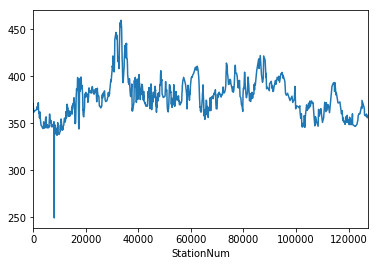

In [390]:
elevation.Elevation.plot()

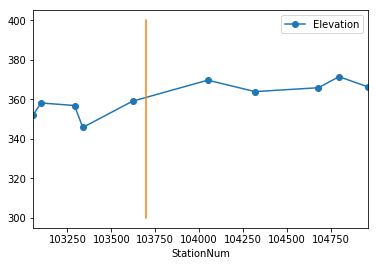

In [691]:
elevation.assign(deltaE=elevation.Elevation.shift(-1)-elevation.Elevation,
                 nextP = np.roll(elevation.index.values,-1),
                deltaP=lambda x: x.nextP-x.index,
                elevation_angle= lambda x: np.arctan(x.deltaE/x.deltaP)*(180/np.pi)).drop(elevation.tail(1).index).query("deltaP>0").loc[slice(103000,105000),['section','Elevation']].groupby('section').plot(marker='o')
plt.plot([103700,103700],[300,400])

# PATTERN ASSESSMENT OF METAL LOSS ANOMALIES

Following cell will determine how many metal loss anomalies are within x.xx [m] of a girth weld.

This is done by querying anything with  US_GWD distance less than x.xx, and DS_GWD - Length/1000 less than x.xx

Metal loss anomalies are classified as per depth ranges.

Swap "df" for "comb_r" to exclude/include POE results respectively.

In [569]:
criteria_tot = [df.ILIFPeakDepthPct.between(0.00,0.1),
           df.ILIFPeakDepthPct.between(0.1,0.2),
           df.ILIFPeakDepthPct.between(0.2,0.4),
           df.ILIFPeakDepthPct.between(0.4,0.6),
           df.ILIFPeakDepthPct.between(0.6,0.8),
           df.ILIFPeakDepthPct.between(0.8,1.0)]

values = ['<10%',
         '10%-20%',
         '20%-40%',
         '40%-60%',
         '60%-80%',
         '>80%']

spacing = 9999
table_columns = ['section',
                'ILIFFeatureNumber',
                'ILIFComment',
                'ILIFPeakDepthPct',
                'ILIFLength',
                'ILIFDistanceFromGirthWeld',
                'dsgwd',
                'FailureYear',
               'FailureMode',
               'FailureProbability',
               'FailureYear_4200',
               'FailureMode_4200',
               'FailureProbability_4200']
# report_col = ['section',
#               'status',
#                'type',
#               'ILIFFeatureNumber',
#                 'ILIFComment',
#                'ILIFPeakDepthPct',
#                'ILIFLength',
#                'ILIFSurfaceInd',
#                'FailureYear',
#                'FailureMode',
#                'FailureProbability',
#                'FailureYear_4200',
#                'FailureMode_4200',
#                'FailureProbability_4200']

comb_r.assign(depth_class = np.select(criteria_tot, values, 0),
                dsgwd = lambda x: x.ILIFDistanceFromGirthWeldDS - x.ILIFLength/1000.0)\
                .query(f"ILIFSurfaceInd=='I' & status=='Active'")\
                .groupby(['ILIFSurfaceInd','status','depth_class'])\
                .count()\
                .sort_values('type', ascending=False)\
                .assign(pct = lambda x: x.type/6072)\
                .loc[:,['type','pct']]

type     pct
ILIFSurfaceInd status depth_class              
I              Active <10%         3554  0.5853
                      10%-20%        14  0.0023